## Setup - imports, time, parameters, size function

In [1]:
runno = '7479'

In [2]:
from invisible_cities.database import load_db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [4]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
from time import time as time
t0 = time()

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

697145

In [54]:
len(histat_events_energy[histat_events_energy > 250])

179232

In [60]:
histat_events_prewindow_sum = np.array(histat_data['events_prewindow_sums'])
histat_events_postwindow_sum = np.array(histat_data['events_postwindow_sums'])

histat_events_energy = np.array(histat_data['events_energy'])
histat_events_energy_subtracted_pre = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_events_energy_subtracted_post = np.array(histat_data['events_energy']) - np.array(histat_data['events_postwindow_sums'])
histat_prepostavg = np.array(histat_data['events_prewindow_sums']) / 2 + np.array(histat_data['events_postwindow_sums']) / 2
histat_events_energy_subtracted_avg = np.array(histat_data['events_energy']) - histat_prepostavg

histat_Zgauss = np.array(histat_data['all_Zgauss'])
histat_Zrms = np.array(histat_data['all_Zrms'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])
histatSRES = np.array(histat_data['all_sres'])
histatSSRES = np.array(histat_data['all_ssres'])

In [38]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histatR2), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted_pre, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 100000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = histat_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

### R2, SRES, SSRES distributions

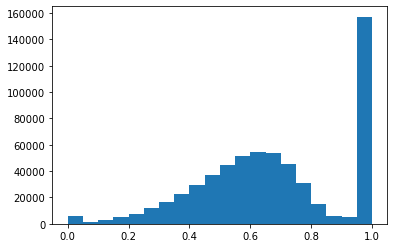

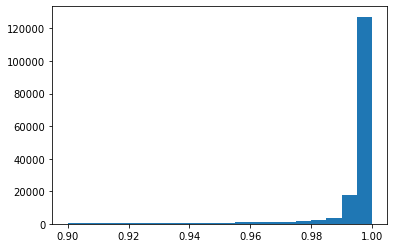

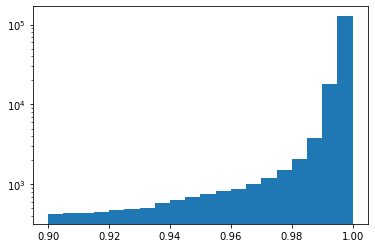

In [12]:
plt.hist(histatR2, range=(0, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.yscale('log')
plt.show()

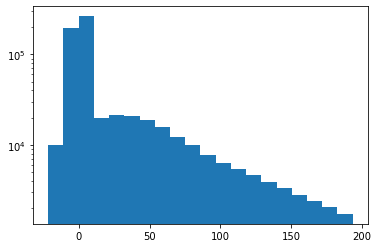

In [13]:
plt.hist(histatSRES, range=(np.percentile( histatSRES, 5), np.percentile( histatSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

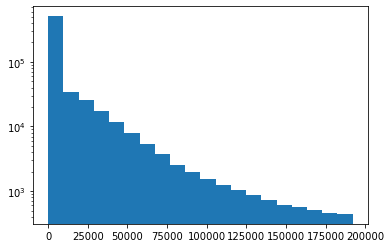

In [14]:
plt.hist(histatSSRES, range=(np.percentile( histatSSRES, 5), np.percentile( histatSSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

## Look at prewindow and postwindow averages to determine if event happened there

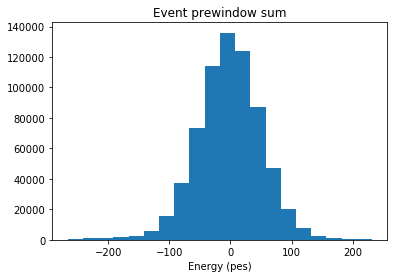

In [15]:
premin = np.percentile(histat_events_prewindow_sum, 2.5)
premax = np.percentile(histat_events_prewindow_sum, 97.5)
premed = np.percentile(histat_events_prewindow_sum, 50)
premin = premed - 2 * (premed - premin)
premax = premed + 2 * (premax - premed)

plt.hist(histat_events_prewindow_sum, range = (premin,premax), bins = 20)
plt.title('Event prewindow sum')
plt.xlabel('Energy (pes)')
plt.show()

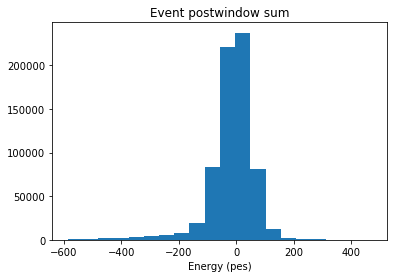

In [16]:
postmin = np.percentile(histat_events_postwindow_sum, 2.5)
postmax = np.percentile(histat_events_postwindow_sum, 97.5)
postmed = np.percentile(histat_events_postwindow_sum, 50)
postmin = premed - 2 * (premed - postmin)
postmax = premed + 2 * (premax - postmed)

plt.hist(histat_events_postwindow_sum, range = (postmin,postmax), bins = 20)
plt.title('Event postwindow sum')
plt.xlabel('Energy (pes)')
plt.show()

In [17]:
# Constant cuts
noise_bound = 0
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events

In [18]:
# Choose your analysis parameters:
# histat_events_energy_subtracted = histat_events_energy_subtracted_pre
# r2cut = 0.98
# histatZ = histat_Zgauss

## Check XYZ distributions

Peak range = 6674.6 , 13542.0
Selected percentage = 10.3 %


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 5.2
200000 / 589977
Est remaining = 5.1
300000 / 589977
Est remaining = 3.7
400000 / 589977
Est remaining = 2.3
500000 / 589977
Est remaining = 1.1


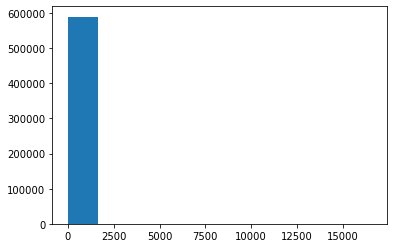

In [61]:
r2cut = 0.9
histatZ = histat_Zgauss
r2mask = histatR2 > r2cut
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
windowcut = (histat_events_postwindow_sum < postmax) & (histat_events_postwindow_sum > postmin) & (histat_events_prewindow_sum < premax) & (histat_events_prewindow_sum > premin)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask & windowcut

med = np.median(histat_events_energy_subtracted_pre[r2ZRhinoisemask])
frac = 0.6827
lowcut = 0.5 - frac / 2
hicut = 0.5 + frac / 2
lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * lowcut))
rgt = med + 3 * (np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * hicut) - med)
print('Peak range =', round(lft,1),',', round(rgt,1))
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted_pre > lft) & (histat_events_energy_subtracted_pre < rgt)
print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '%')

# Create own correction map
nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted_pre[xymask & histat_selfmask])

energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

# Apply the correction
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted_pre, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5

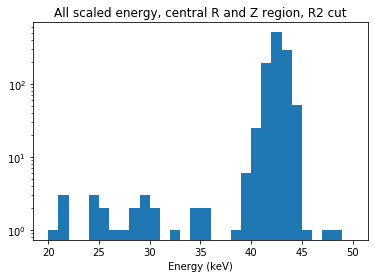

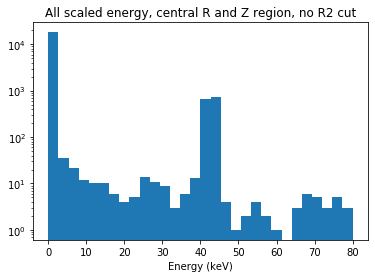

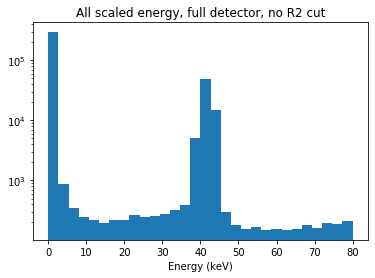

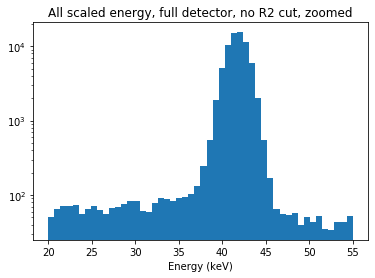

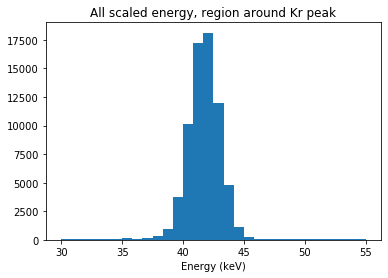

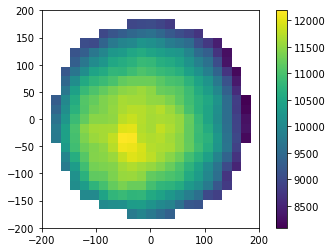

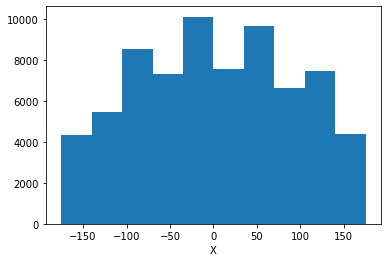

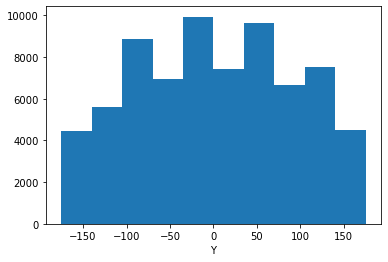

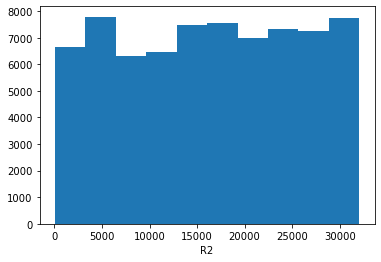

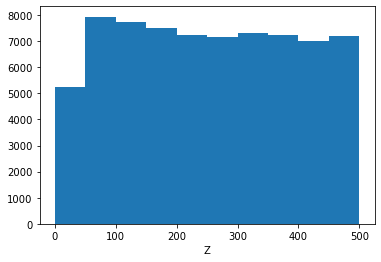

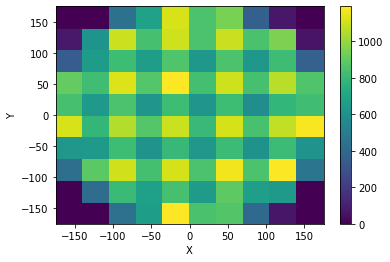

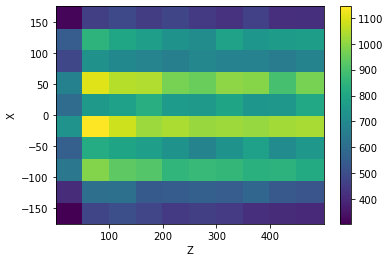

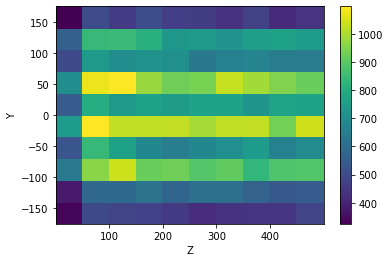

In [62]:
# Final cut spectra, corrected
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (20, 50), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 180**2) & (histatZ[histat_nomask] < 450)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, full detector, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 180**2) & (histatZ[histat_nomask] < 450)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (20, 55), bins = 50)
plt.title('All scaled energy, full detector, no R2 cut, zoomed')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.title('All scaled energy, region around Kr peak')
plt.xlabel('Energy (keV)')
plt.show()


plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
plt.colorbar()
plt.show()

histatR = np.sqrt(histatX**2 + histatY**2)

plt.hist(histatX[histat_selfmask])
plt.xlabel('X')
plt.show()

plt.hist(histatY[histat_selfmask])
plt.xlabel('Y')
plt.show()

plt.hist(histatR[histat_selfmask]**2)
plt.xlabel('R2')
plt.show()

plt.hist(histatZ[histat_selfmask])
plt.xlabel('Z')
plt.show()

h = plt.hist2d(histatX[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatX[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('X')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

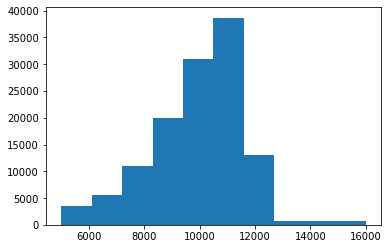

In [35]:
plt.hist(histat_events_energy_subtracted_pre, range=(5000,16000))
plt.show()

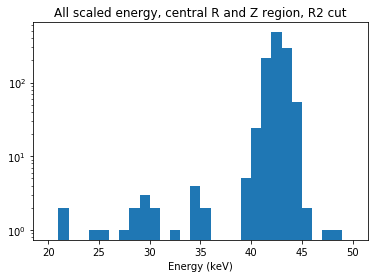

In [56]:
# Final cut spectra, corrected
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (20, 50), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()


In [49]:
len(histat_events_energy_subtracted_pre)

697145

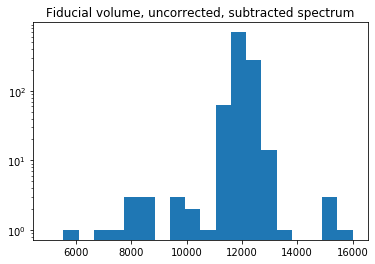

In [53]:
histatZ = histat_Zgauss
zmask = (histatZ > 0) & (histatZ < 100)
rmask = histatX**2 + histatY**2 < 50**2
r2ZRnoisemask = zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
windowcut = (histat_events_postwindow_sum < postmax) & (histat_events_postwindow_sum > postmin) & (histat_events_prewindow_sum < premax) & (histat_events_prewindow_sum > premin)
r2ZRhinoisemask = r2ZRnoisemask & windowcut

plt.hist(histat_events_energy_subtracted_pre[r2ZRhinoisemask], range=(5000,16000), bins = 20)
plt.title('Fiducial volume, uncorrected, subtracted spectrum')
plt.yscale('log')
plt.show()

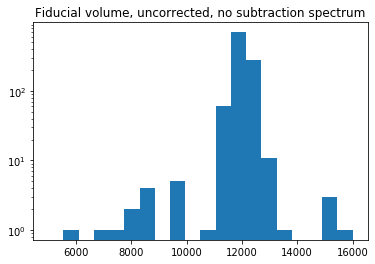

In [52]:
histatZ = histat_Zgauss
zmask = (histatZ > 0) & (histatZ < 100)
rmask = histatX**2 + histatY**2 < 50**2
r2ZRnoisemask = zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
windowcut = (histat_events_postwindow_sum < postmax) & (histat_events_postwindow_sum > postmin) & (histat_events_prewindow_sum < premax) & (histat_events_prewindow_sum > premin)
r2ZRhinoisemask = r2ZRnoisemask & windowcut

plt.hist(histat_events_energy[r2ZRhinoisemask], range=(5000,16000), bins = 20)
plt.title('Fiducial volume, uncorrected, no subtraction spectrum')
plt.yscale('log')
plt.show()

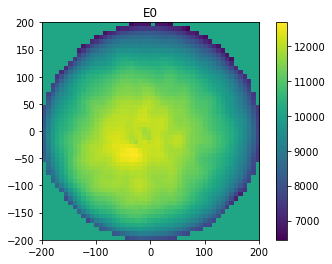

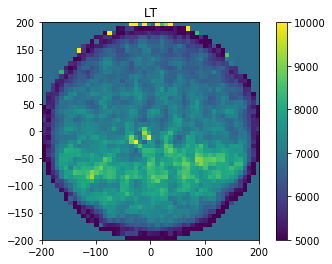

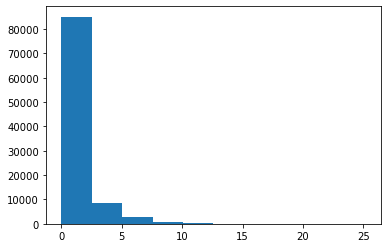

Fit a Gaussian with guess (A0, m0, s0) = (232.0, 1, 1.0549670056383043)


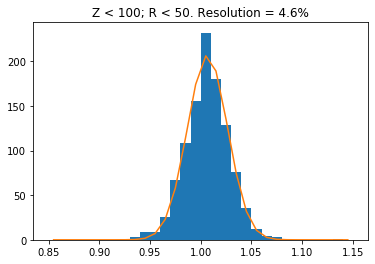

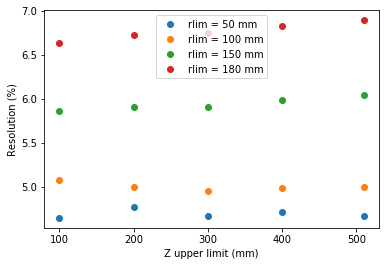

Innermost resolution =  4.64 %
Outermost resolution =  6.89 %


In [39]:
# Bootstrap with the correction maps from 7472
histatZ = histat_Zgauss
zmax = 500
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
ZRmask =  zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
# hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
windowcut = (histat_events_postwindow_sum < postmax) & (histat_events_postwindow_sum > postmin) & (histat_events_prewindow_sum < premax) & (histat_events_prewindow_sum > premin)
ZRwindowmask = ZRmask & windowcut

file_7472   = '/Volumes/NEXT_Data/IC_Data/st190819/maps/kr_emap_xy_50_50_r_7472_st190819.h5'

e0_7472, lt_7472, bounds_7472 = load_maps_from_file(file_7472)
r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = ZRwindowmask, ltmap = lt_7472, energies = histat_events_energy_subtracted_pre)
r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = ZRwindowmask)
plot_res_vs_zr(r7472_res_vs_zr)

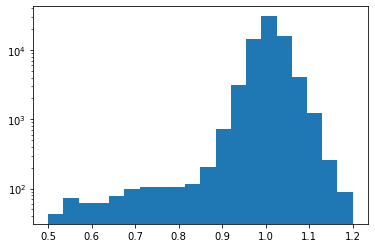

In [42]:
plt.hist(r7472_scaled_energy, range=(0.5, 1.2), bins = 20)
plt.yscale('log')
plt.show()

In [44]:
len(r7472_scaled_energy) - len(ZRwindowmask)

-599948

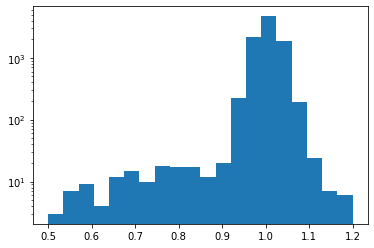

In [45]:
zmask = (histatZ > 0) & (histatZ < 100)
rmask = histatX**2 + histatY**2 < 150**2

fidmask = zmask[ZRwindowmask] & rmask[ZRwindowmask]

plt.hist(r7472_scaled_energy[fidmask], range=(0.5, 1.2), bins = 20)
plt.yscale('log')
plt.show()

In [20]:
def check_resolution(histatZ, histat_events_energy_subtracted, r2cut):

    # Create masks
    r2mask = histatR2 > r2cut
    zmask = (histatZ > 0) & (histatZ < zmax)
    rmask = histatX**2 + histatY**2 < 180**2
    r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
    hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
    windowcut = (histat_events_postwindow_sum < postmax) & (histat_events_postwindow_sum > postmin) & (histat_events_prewindow_sum < premax) & (histat_events_prewindow_sum > premin)
    r2ZRhinoisemask = r2ZRnoisemask & hienergymask & windowcut

    # Set peak range
    med = np.median(histat_events_energy_subtracted[r2ZRhinoisemask])
    frac = 0.6827
    lowcut = 0.5 - frac / 2
    hicut = 0.5 + frac / 2
    lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * lowcut))
    rgt = med + 3 * (np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * hicut) - med)
    print('Peak range =', round(lft,1),',', round(rgt,1))
    histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)
    print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '\%')
    
    # Plot spectra after applying various cuts
    plt.hist(histat_events_energy_subtracted, bins = 25)
    plt.yscale('log')
    plt.title('Full spectrum')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
    plt.xlabel('Energy (pes)')
    plt.show()

    # Noise spectrum
    plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
    plt.title('Noise spectrum')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
    plt.title('Noise spectrum, bad R2')
    plt.yscale('log')
    plt.show()

    # Create own correction map
    nbins = 23
    clim = 200
    dbin = 2 * clim / nbins
    coord_range = np.linspace(-clim, clim, nbins + 1)
    coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

    energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
    events_sum = np.zeros((len(coord_bins),len(coord_bins)))
    for ix in range(len(coord_bins)):
        for iy in range(len(coord_bins)):
            xbin = coord_bins[ix]
            ybin = coord_bins[iy]
            xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
            ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
            xymask = xmask & ymask
            events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
            energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])

    energy_xy = energy_sum / events_sum
    energy_xy_bounds = ((-200, 200), (-200, 200))

    plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    map_out = './maps_from_maxsipm/map_'+runno+'.npy'

    with open(map_out, 'wb') as f:
        np.save(f, energy_xy)

    with open(map_out, 'rb') as f:
        test_readin_xy = np.load(f)

    plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    # Apply the correction
    histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
    histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
    histat_all_scaled_energy *= 41.5

    plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
    plt.title('All scaled energy')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    # Final cut spectra
    histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, no R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
    plt.title('All scaled energy, region around Kr peak, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.show()

    # r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
    # r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
    histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

    histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histatZ)
    plot_res_vs_zr(histat_self_res_vs_zr)
    print('All resolutions:', histat_self_res_vs_zr)
    
    return histat_self_res_vs_zr


================ CHECKING R2 CUT = 0.4 ================
Peak range = 5780.5 , 13651.9
Selected percentage = 10.6 \%


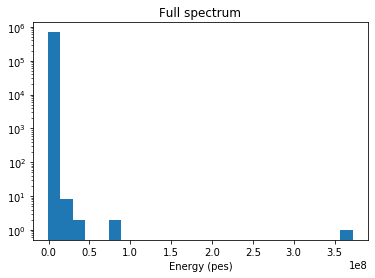

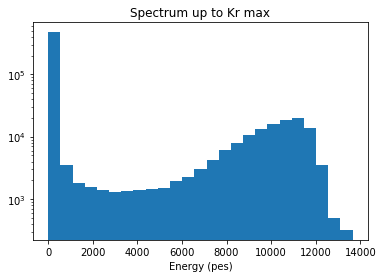

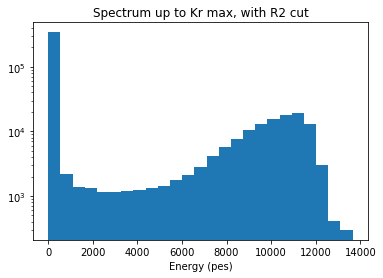

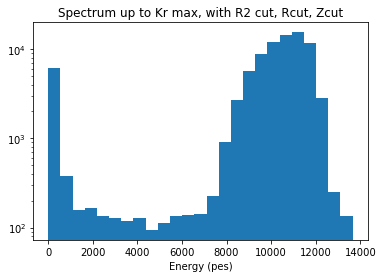

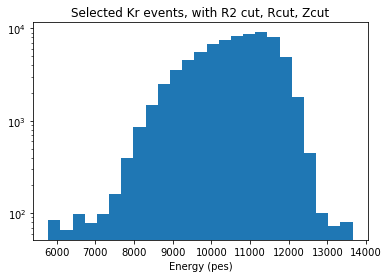

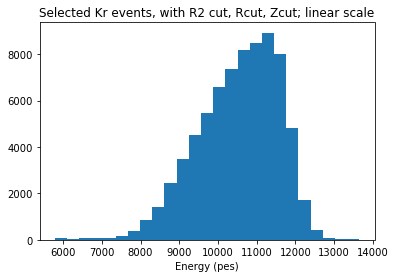

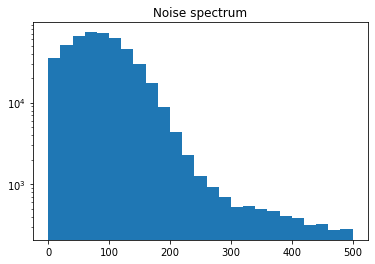

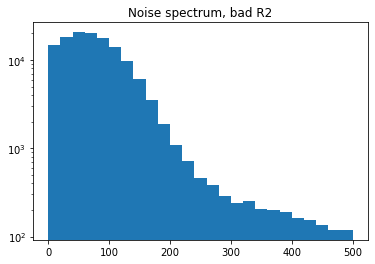

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


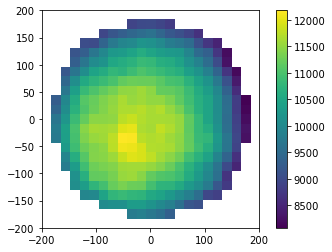

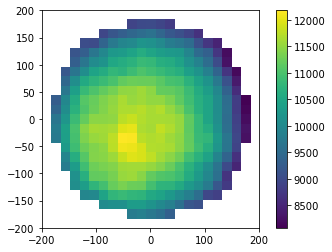

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 8.5
200000 / 589977
Est remaining = 6.7
300000 / 589977
Est remaining = 5.1
400000 / 589977
Est remaining = 3.2
500000 / 589977
Est remaining = 1.5


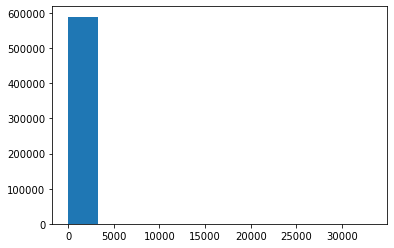

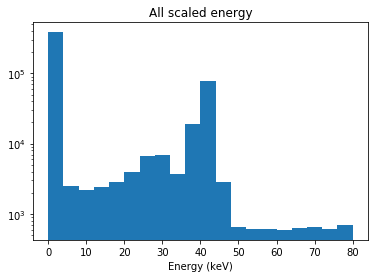

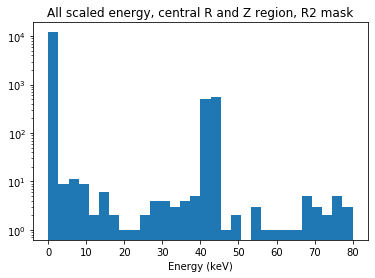

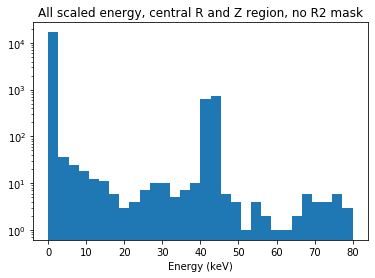

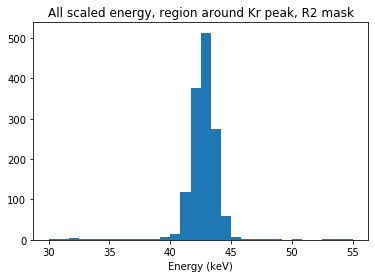

Correcting energies...
0 / 73686


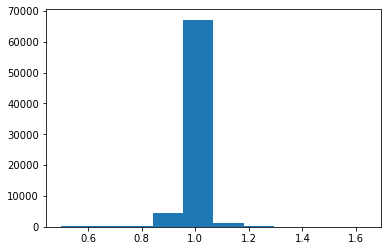

Fit a Gaussian with guess (A0, m0, s0) = (209.0, 1, 0.04135796156643845)


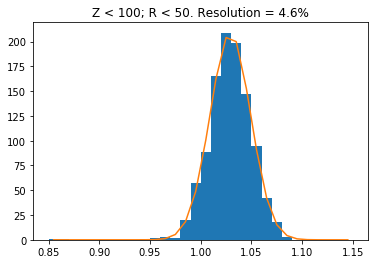

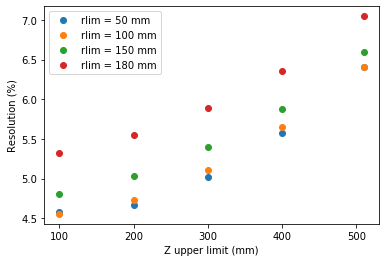

Innermost resolution =  4.58 %
Outermost resolution =  7.05 %
All resolutions: {100050: 4.582028479692865, 100100: 4.555156619888622, 100150: 4.810924177473044, 100180: 5.326910665814581, 200050: 4.670921796553121, 200100: 4.725046684781716, 200150: 5.03587621245998, 200180: 5.544582731886664, 300050: 5.024982819902224, 300100: 5.102324162031055, 300150: 5.398200494061267, 300180: 5.886071741901232, 400050: 5.572513547786477, 400100: 5.655014803973778, 400150: 5.882550402054248, 400180: 6.358393393393536, 510050: 6.404945897500119, 510100: 6.4117289067843535, 510150: 6.595417414093274, 510180: 7.045278457217256}

================ CHECKING R2 CUT = 0.5 ================
Peak range = 5947.2 , 13634.8
Selected percentage = 10.6 \%


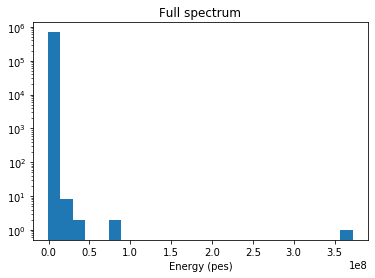

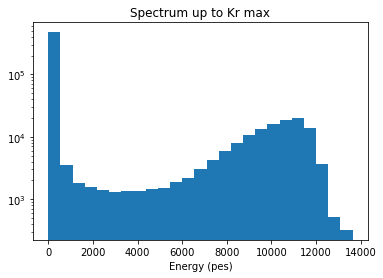

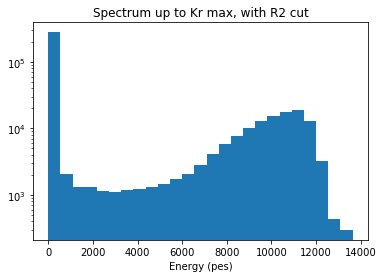

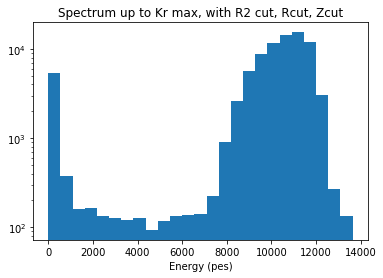

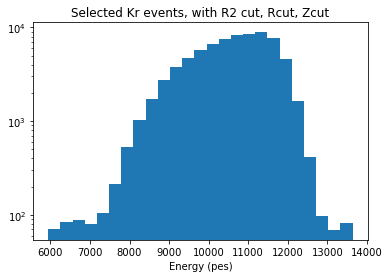

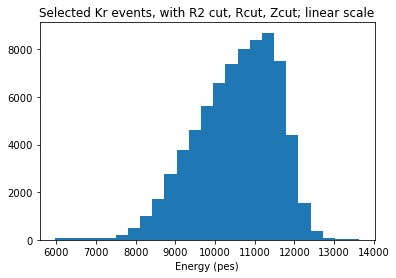

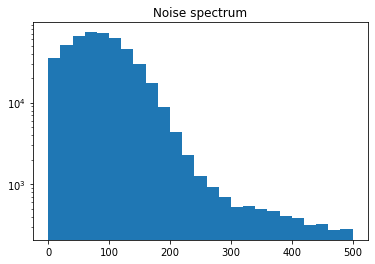

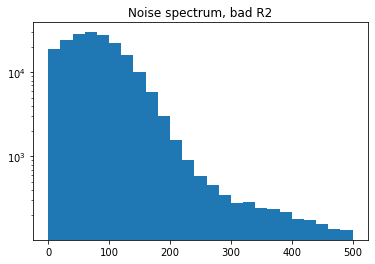

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


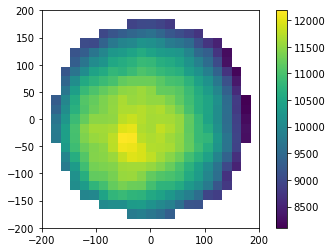

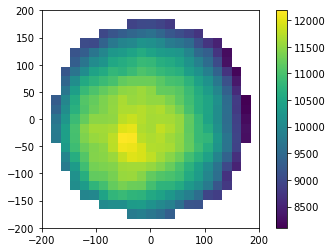

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.6
200000 / 589977
Est remaining = 5.6
300000 / 589977
Est remaining = 4.2
400000 / 589977
Est remaining = 2.7
500000 / 589977
Est remaining = 1.3


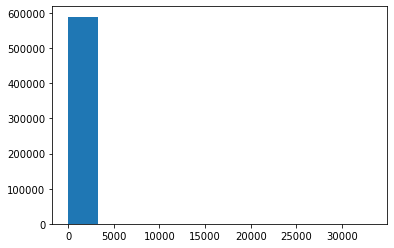

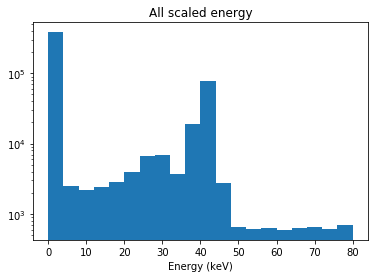

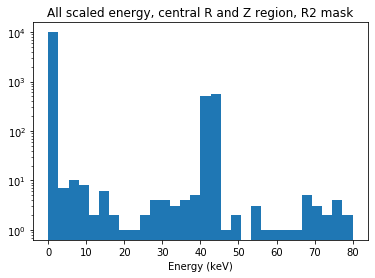

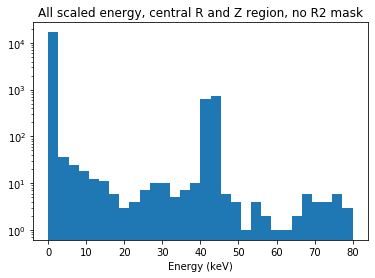

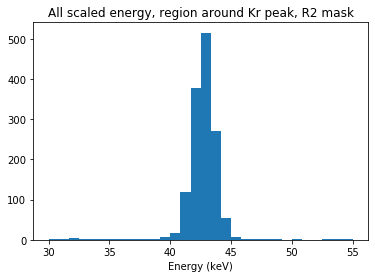

Correcting energies...
0 / 73644


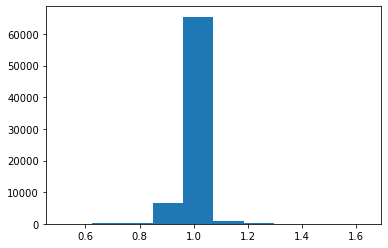

Fit a Gaussian with guess (A0, m0, s0) = (210.0, 1, 0.04133611799781493)


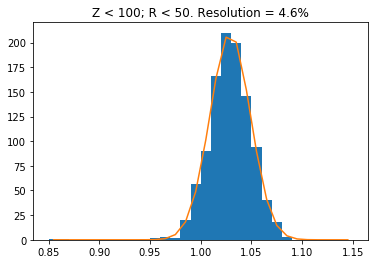

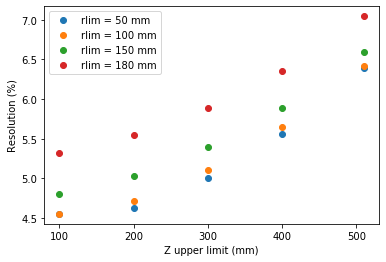

Innermost resolution =  4.56 %
Outermost resolution =  7.04 %
All resolutions: {100050: 4.55597128004826, 100100: 4.552326122884734, 100150: 4.8054458626164545, 100180: 5.321957605138005, 200050: 4.631861761485369, 200100: 4.719522822214705, 200150: 5.0365878306998475, 200180: 5.543484318849401, 300050: 5.0083549742519065, 300100: 5.102915057831443, 300150: 5.402135491844781, 300180: 5.887647034203307, 400050: 5.557166912847107, 400100: 5.650487131064762, 400150: 5.882014650902732, 400180: 6.356101187942644, 510050: 6.396605080797069, 510100: 6.411870809803764, 510150: 6.596252273472382, 510180: 7.044410274807728}

================ CHECKING R2 CUT = 0.6 ================
Peak range = 6140.7 , 13611.7
Selected percentage = 10.6 \%


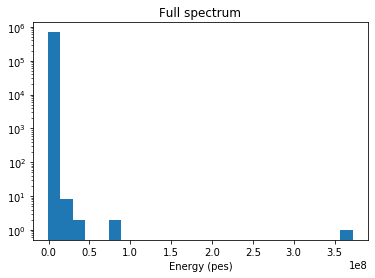

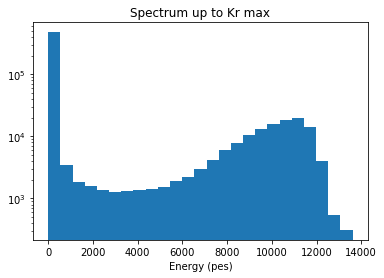

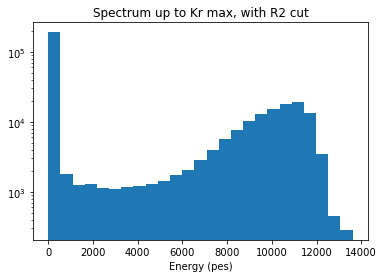

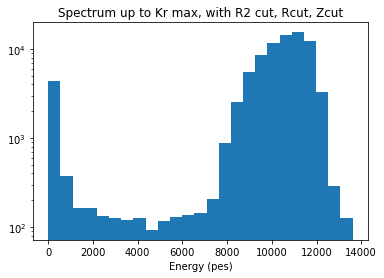

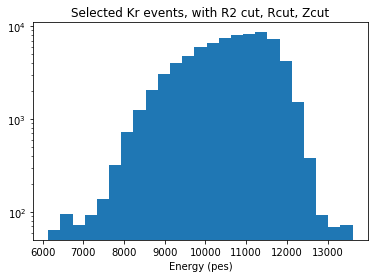

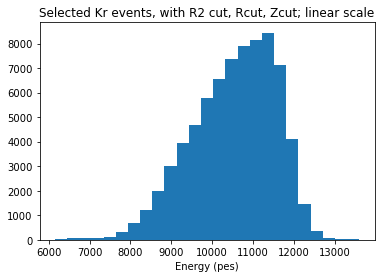

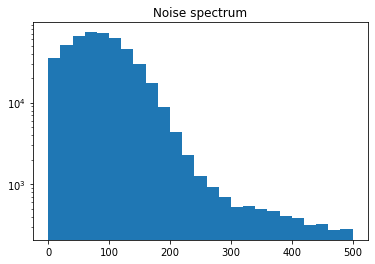

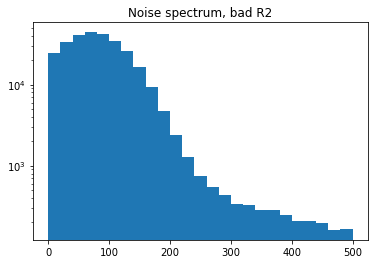

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


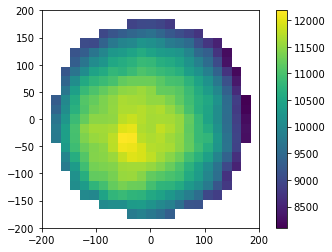

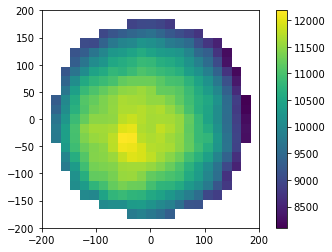

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.8
200000 / 589977
Est remaining = 5.3
300000 / 589977
Est remaining = 3.9
400000 / 589977
Est remaining = 2.6
500000 / 589977
Est remaining = 1.2


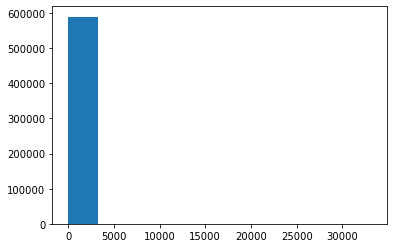

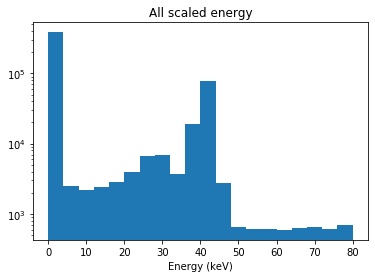

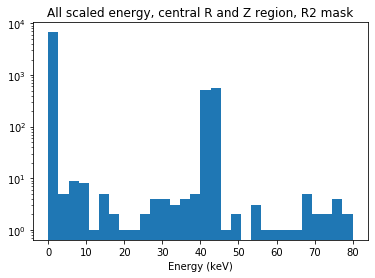

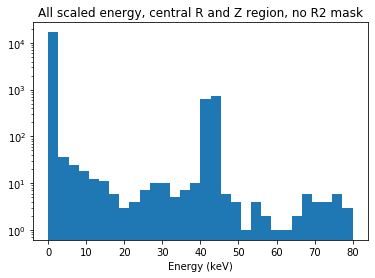

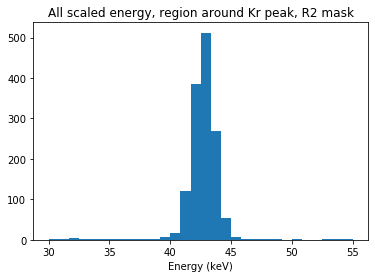

Correcting energies...
0 / 73587


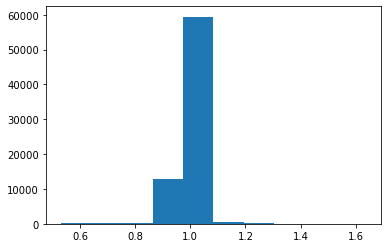

Fit a Gaussian with guess (A0, m0, s0) = (207.0, 1, 0.03814780362102332)


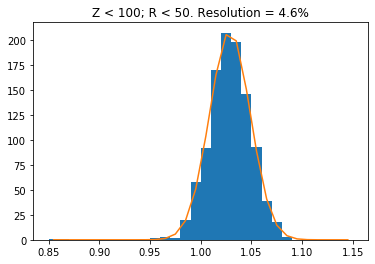

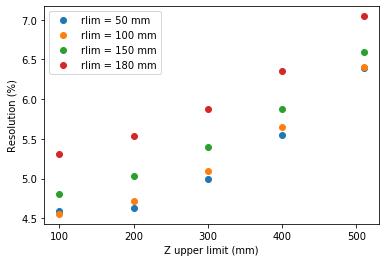

Innermost resolution =  4.59 %
Outermost resolution =  7.04 %
All resolutions: {100050: 4.588504657128424, 100100: 4.556251511203072, 100150: 4.8070280974790345, 100180: 5.316198061839304, 200050: 4.6322656465692775, 200100: 4.712660126243362, 200150: 5.030182185880622, 200180: 5.531176492615958, 300050: 5.001957487956013, 300100: 5.098817689760687, 300150: 5.396141634218383, 300180: 5.879159074077627, 400050: 5.5491362184066055, 400100: 5.646671590473917, 400150: 5.880680453535885, 400180: 6.352168842106659, 510050: 6.397655463857393, 510100: 6.409125375041116, 510150: 6.598171024345602, 510180: 7.044215637472493}

================ CHECKING R2 CUT = 0.7 ================
Peak range = 6382.6 , 13585.9
Selected percentage = 10.5 \%


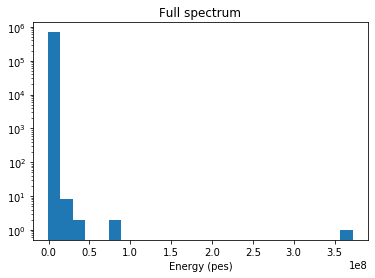

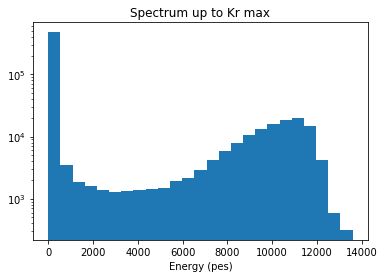

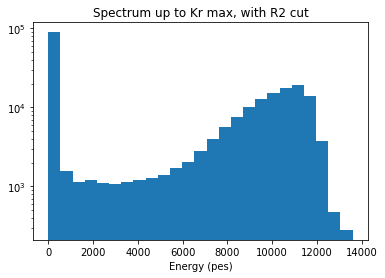

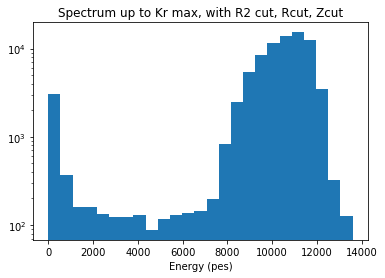

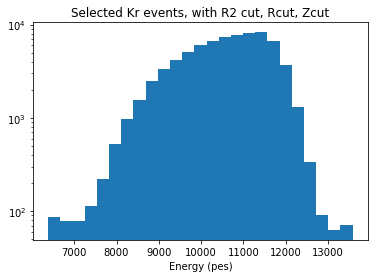

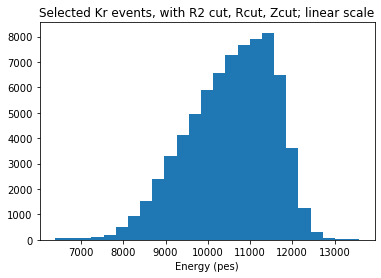

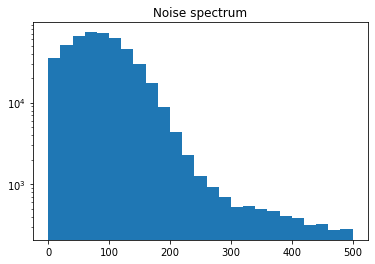

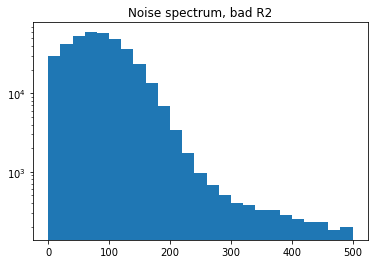

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


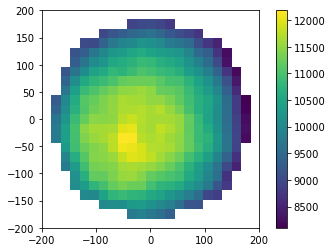

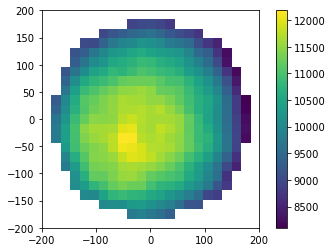

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.6
200000 / 589977
Est remaining = 5.1
300000 / 589977
Est remaining = 3.8
400000 / 589977
Est remaining = 2.5
500000 / 589977
Est remaining = 1.2


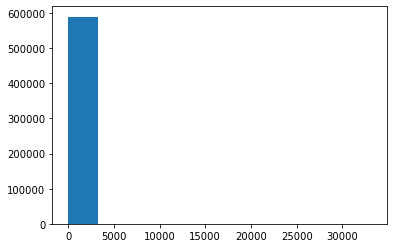

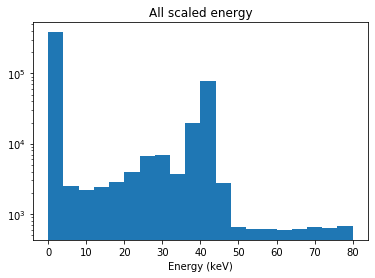

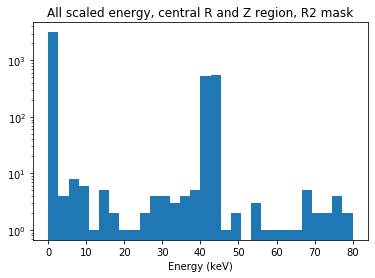

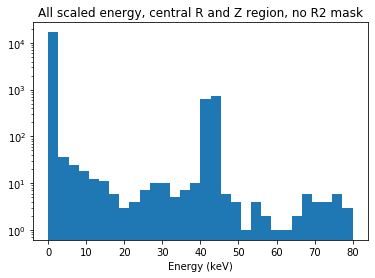

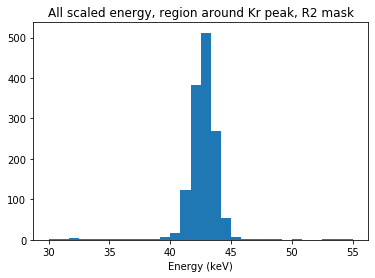

Correcting energies...
0 / 73507


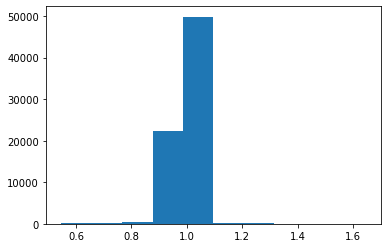

Fit a Gaussian with guess (A0, m0, s0) = (209.0, 1, 0.038138190310786205)


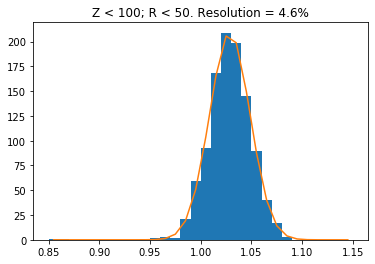

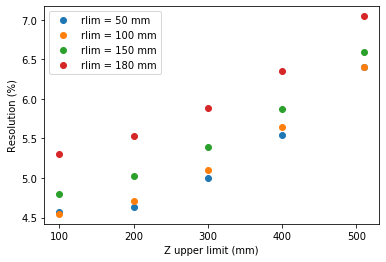

Innermost resolution =  4.57 %
Outermost resolution =  7.04 %
All resolutions: {100050: 4.572296574191939, 100100: 4.545331213093841, 100150: 4.798077316556131, 100180: 5.3052827997466325, 200050: 4.628101401681125, 200100: 4.708376393440579, 200150: 5.0234609463230475, 200180: 5.525420211498748, 300050: 5.002530617848237, 300100: 5.095402720853414, 300150: 5.393793536177806, 300180: 5.879267579120373, 400050: 5.5478087734414, 400100: 5.63982267330895, 400150: 5.87706289170096, 400180: 6.351501050293298, 510050: 6.396982337651462, 510100: 6.4044923416692745, 510150: 6.596864382895373, 510180: 7.043872098474952}

================ CHECKING R2 CUT = 0.8 ================
Peak range = 6596.3 , 13561.5
Selected percentage = 10.5 \%


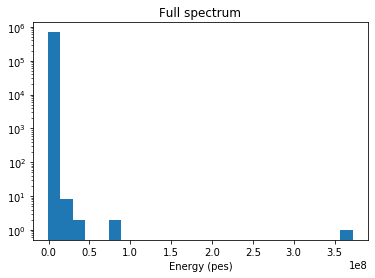

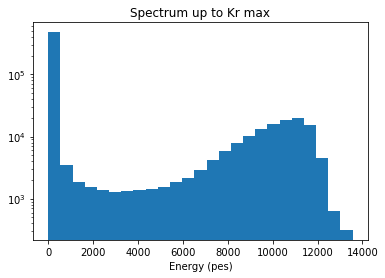

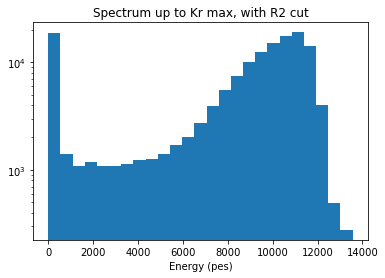

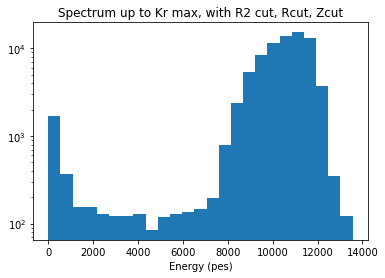

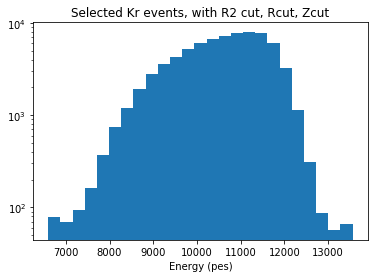

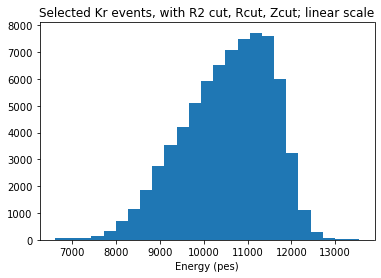

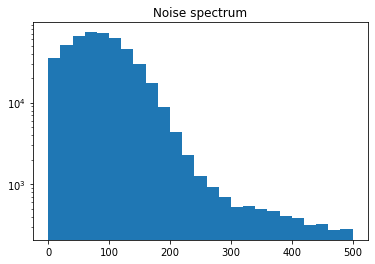

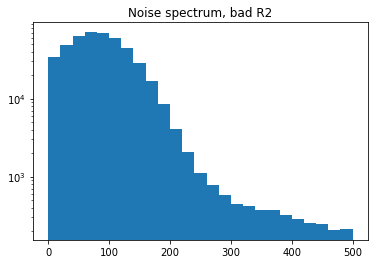

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


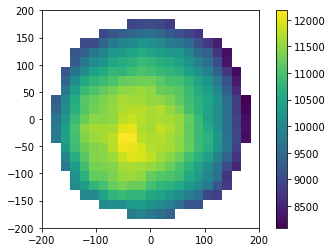

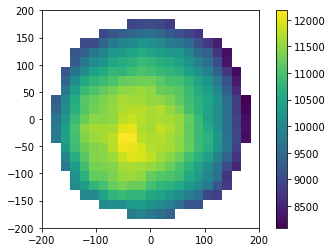

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.5
200000 / 589977
Est remaining = 5.0
300000 / 589977
Est remaining = 3.7
400000 / 589977
Est remaining = 2.4
500000 / 589977
Est remaining = 1.2


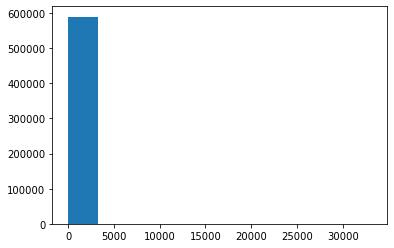

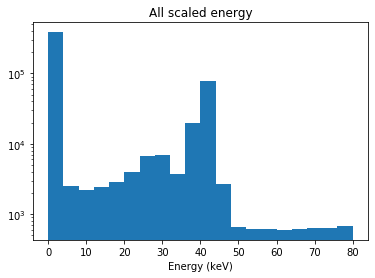

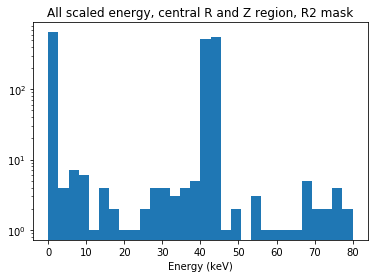

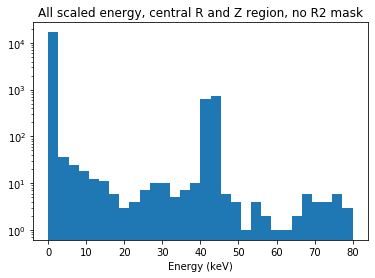

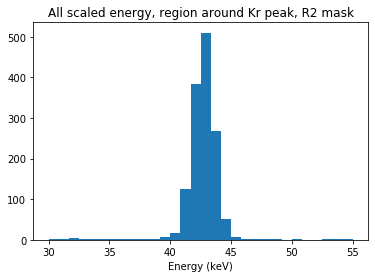

Correcting energies...
0 / 73213


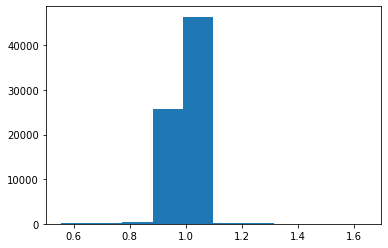

Fit a Gaussian with guess (A0, m0, s0) = (209.0, 1, 0.03816571552251064)


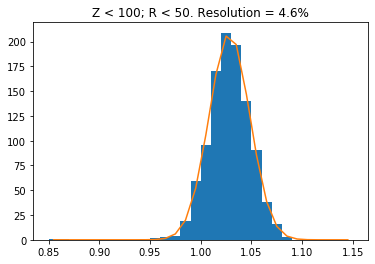

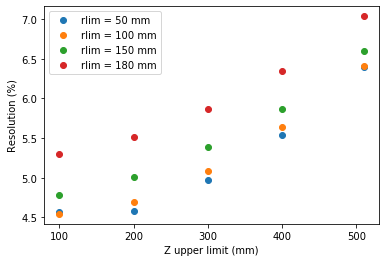

Innermost resolution =  4.57 %
Outermost resolution =  7.04 %
All resolutions: {100050: 4.573931528406477, 100100: 4.54426300249978, 100150: 4.788794612751534, 100180: 5.297424517363292, 200050: 4.582476631626868, 200100: 4.697019618960202, 200150: 5.010771664956922, 200180: 5.513760722855225, 300050: 4.973303052037645, 300100: 5.088954986788677, 300150: 5.385771641819507, 300180: 5.867224855146178, 400050: 5.534291908374562, 400100: 5.6360265982160005, 400150: 5.870490660821704, 400180: 6.340247593574636, 510050: 6.3979097379572485, 510100: 6.4047801461049625, 510150: 6.593148195755383, 510180: 7.036449015575271}

================ CHECKING R2 CUT = 0.9 ================
Peak range = 6685.0 , 13543.3
Selected percentage = 10.5 \%


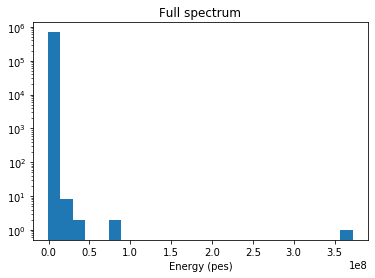

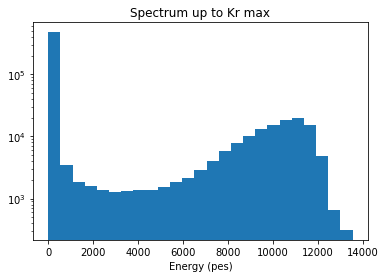

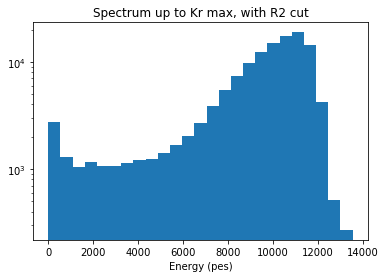

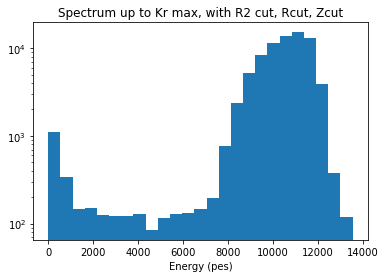

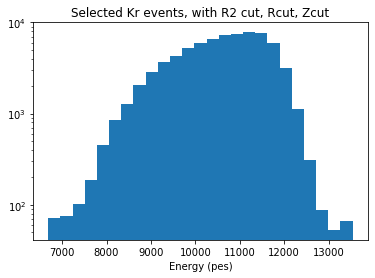

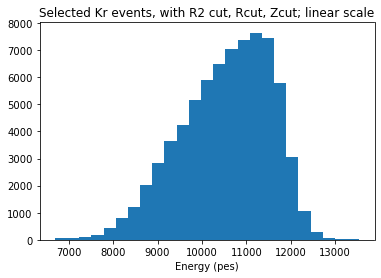

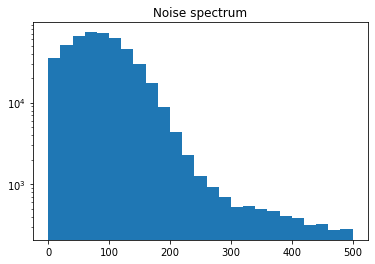

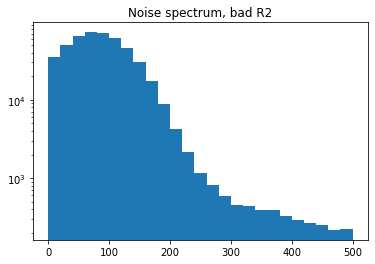

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


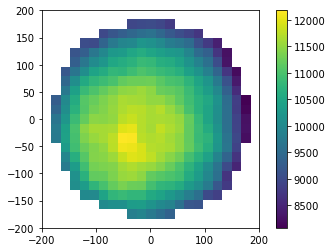

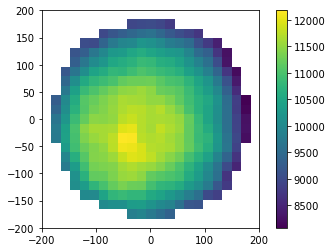

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.6
200000 / 589977
Est remaining = 5.2
300000 / 589977
Est remaining = 3.9
400000 / 589977
Est remaining = 2.5
500000 / 589977
Est remaining = 1.2


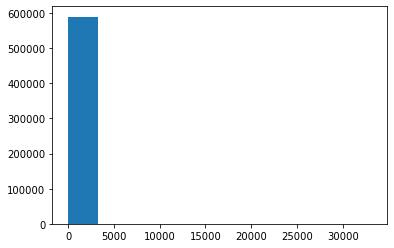

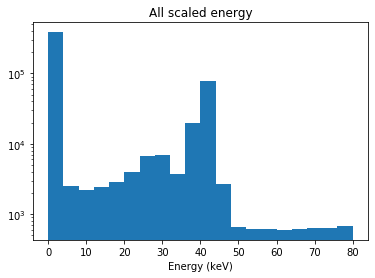

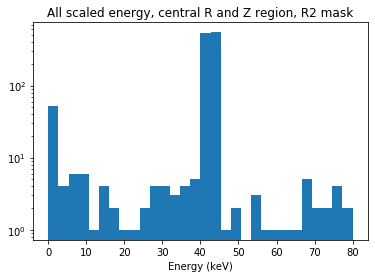

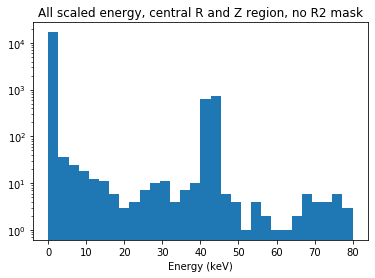

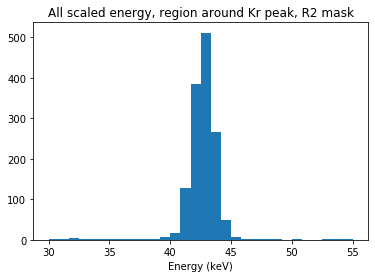

Correcting energies...
0 / 72993


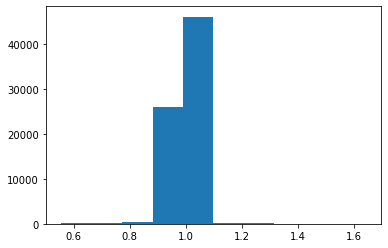

Fit a Gaussian with guess (A0, m0, s0) = (213.0, 1, 0.03819458387143255)


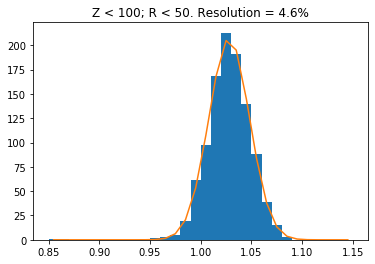

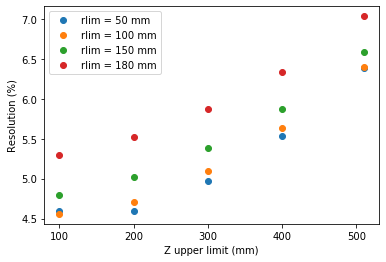

Innermost resolution =  4.59 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.589939468387972, 100100: 4.557788496964596, 100150: 4.798979610306696, 100180: 5.298312806699287, 200050: 4.589574729435558, 200100: 4.704209899456848, 200150: 5.016852004081788, 200180: 5.517355233805127, 300050: 4.976058417366219, 300100: 5.091746304165566, 300150: 5.385011677076099, 300180: 5.866307211663332, 400050: 5.531031931930349, 400100: 5.636358213770477, 400150: 5.86870671220523, 400180: 6.338110098778607, 510050: 6.390255595642891, 510100: 6.402320979865172, 510150: 6.58907055751231, 510180: 7.032671083478491}

================ CHECKING R2 CUT = 0.92 ================
Peak range = 6703.8 , 13540.8
Selected percentage = 10.5 \%


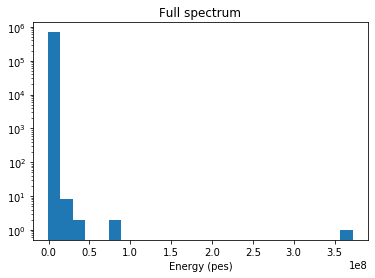

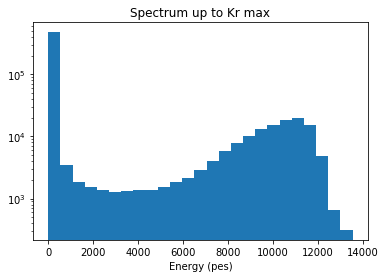

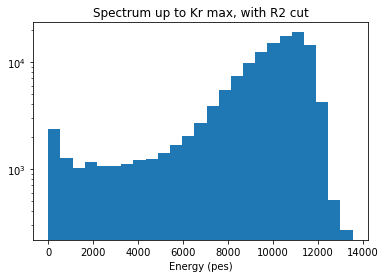

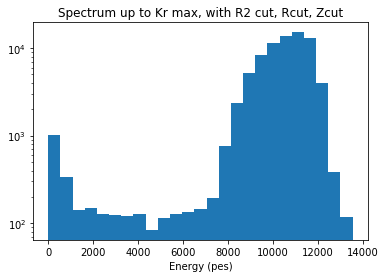

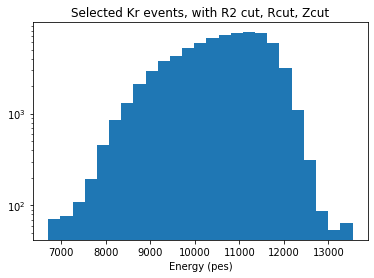

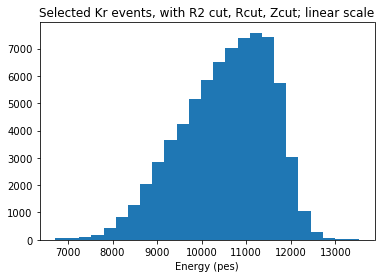

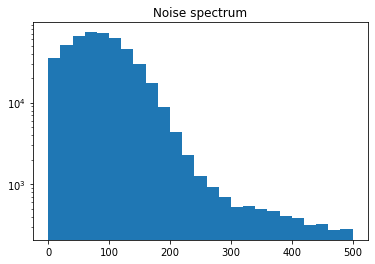

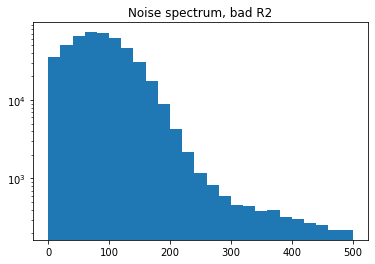

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


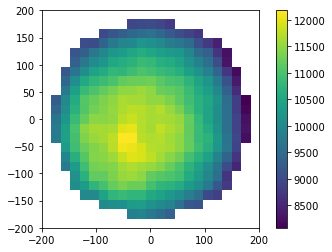

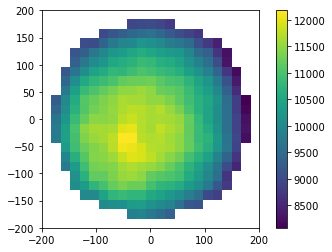

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 7.0
200000 / 589977
Est remaining = 5.4
300000 / 589977
Est remaining = 3.9
400000 / 589977
Est remaining = 2.5
500000 / 589977
Est remaining = 1.2


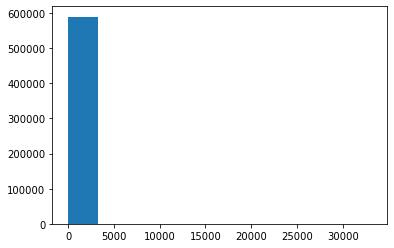

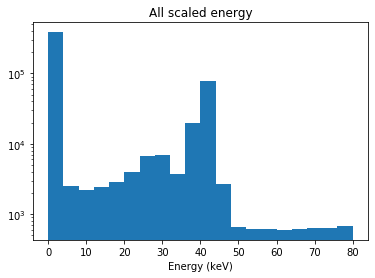

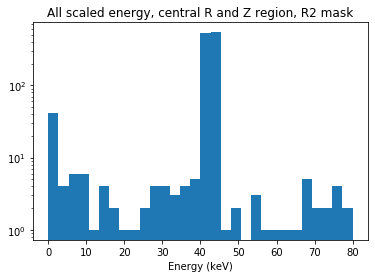

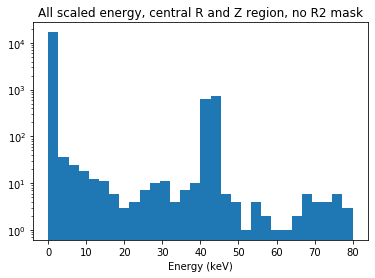

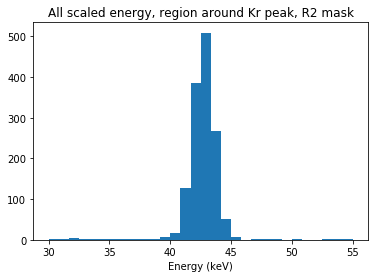

Correcting energies...
0 / 72932


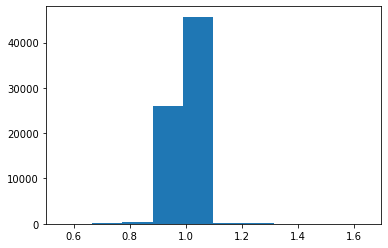

Fit a Gaussian with guess (A0, m0, s0) = (210.0, 1, 0.038195590699102985)


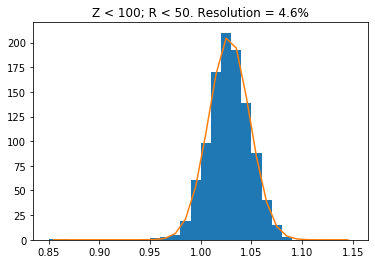

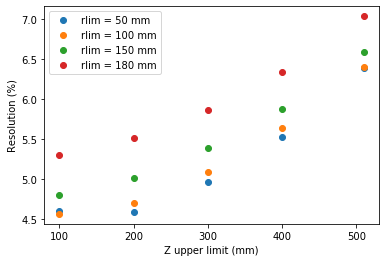

Innermost resolution =  4.61 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.606813669979726, 100100: 4.564334602532679, 100150: 4.802754258284707, 100180: 5.302250397979114, 200050: 4.593448418899559, 200100: 4.70354310511284, 200150: 5.018079797429092, 200180: 5.516963820761107, 300050: 4.968947970704953, 300100: 5.087833830008889, 300150: 5.385927847034264, 300180: 5.86585739408055, 400050: 5.52439488843227, 400100: 5.633672889057401, 400150: 5.869802532390403, 400180: 6.338411158258935, 510050: 6.386768754617339, 510100: 6.400023685529851, 510150: 6.589231630882523, 510180: 7.032491196572089}

================ CHECKING R2 CUT = 0.94 ================
Peak range = 6713.1 , 13536.0
Selected percentage = 10.5 \%


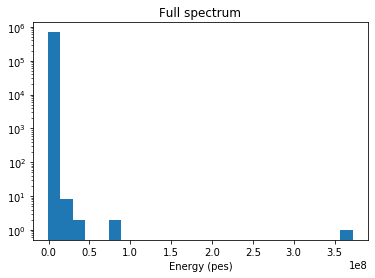

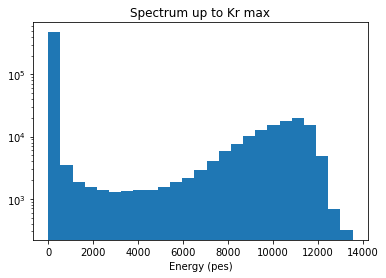

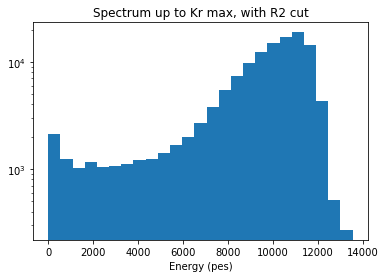

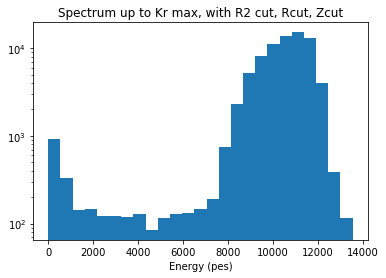

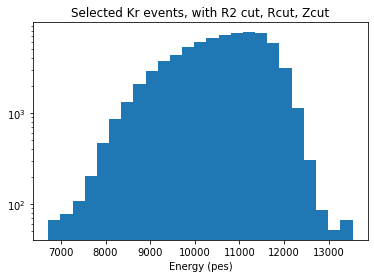

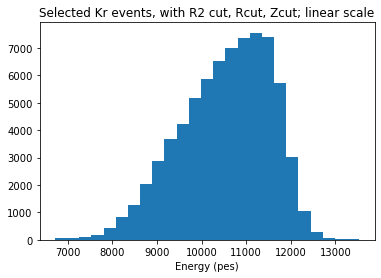

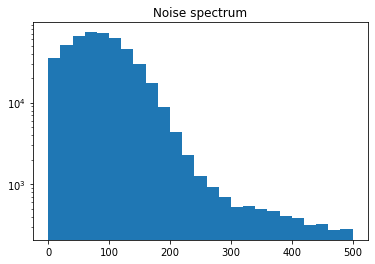

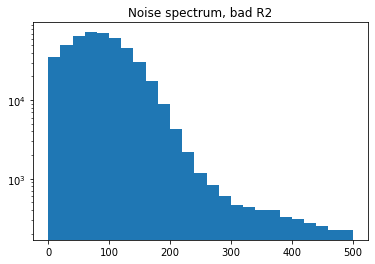

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


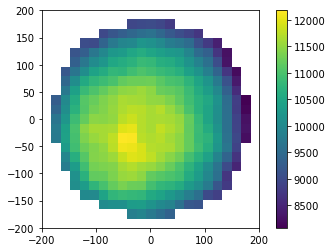

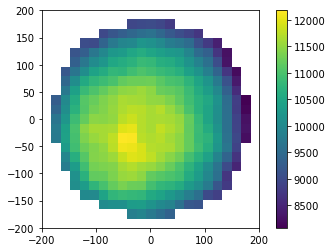

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 8.8
200000 / 589977
Est remaining = 6.2
300000 / 589977
Est remaining = 4.3
400000 / 589977
Est remaining = 2.8
500000 / 589977
Est remaining = 1.4


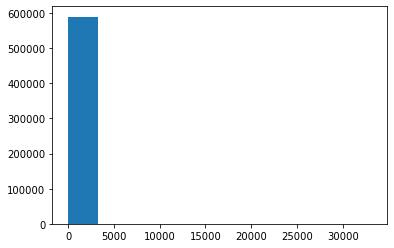

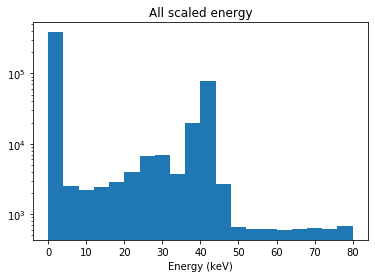

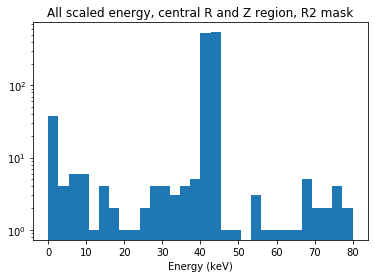

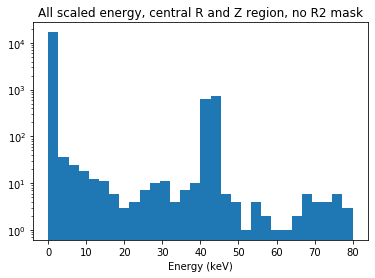

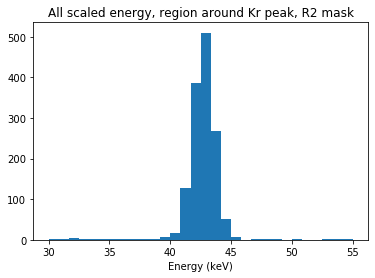

Correcting energies...
0 / 72855


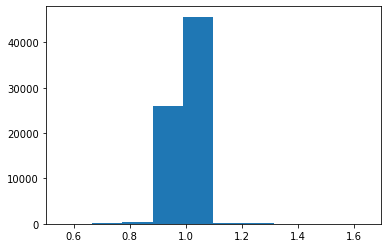

Fit a Gaussian with guess (A0, m0, s0) = (209.0, 1, 0.038197970344870096)


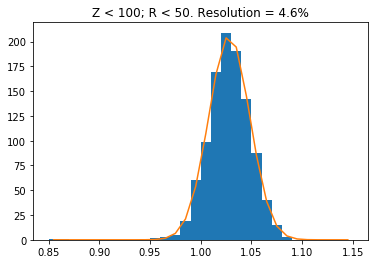

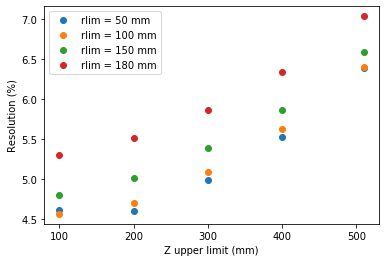

Innermost resolution =  4.62 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.621828806947868, 100100: 4.56923570601768, 100150: 4.802919622141791, 100180: 5.301383504895001, 200050: 4.609687890470092, 200100: 4.702872637524477, 200150: 5.014196523555217, 200180: 5.515634084163815, 300050: 4.986217695328646, 300100: 5.088225917542057, 300150: 5.384960102596504, 300180: 5.866838595366378, 400050: 5.530507393177997, 400100: 5.632120560975227, 400150: 5.868887579630164, 400180: 6.3385946549847425, 510050: 6.3912160982024755, 510100: 6.398684205013193, 510150: 6.587671120455459, 510180: 7.031921215633795}

================ CHECKING R2 CUT = 0.96 ================
Peak range = 6726.4 , 13531.8
Selected percentage = 10.4 \%


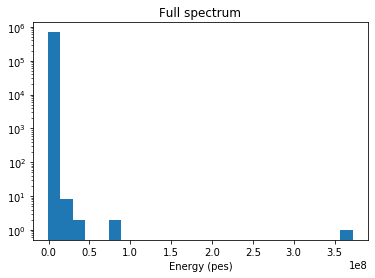

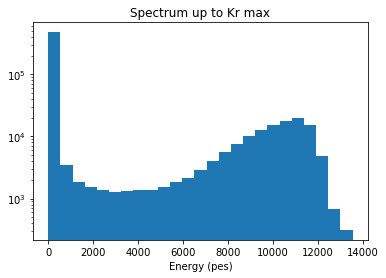

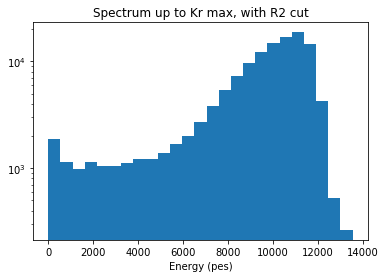

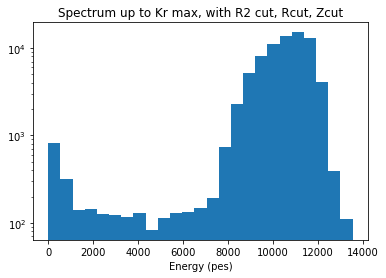

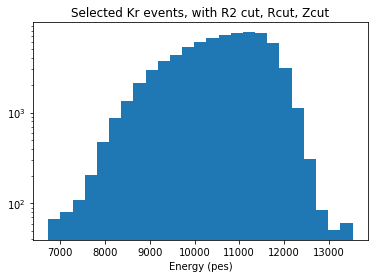

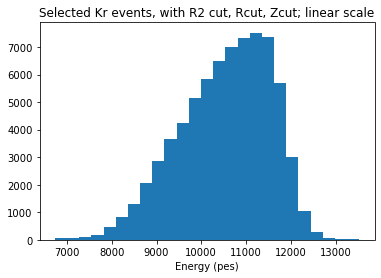

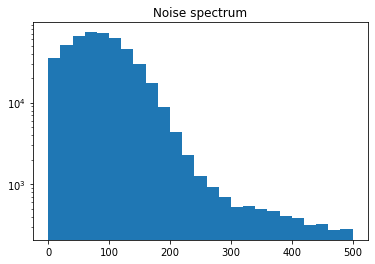

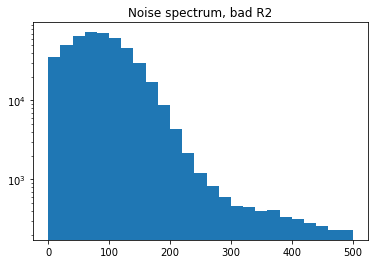

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


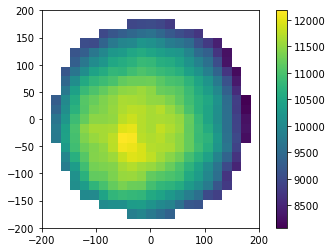

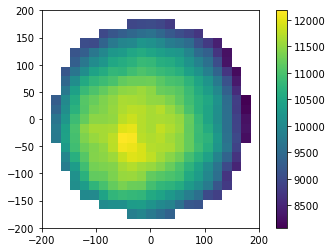

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.8
200000 / 589977
Est remaining = 5.9
300000 / 589977
Est remaining = 4.2
400000 / 589977
Est remaining = 2.6
500000 / 589977
Est remaining = 1.2


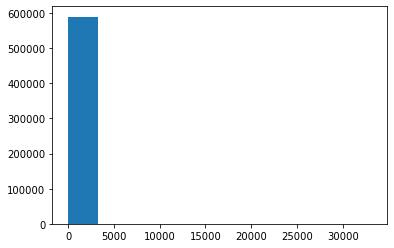

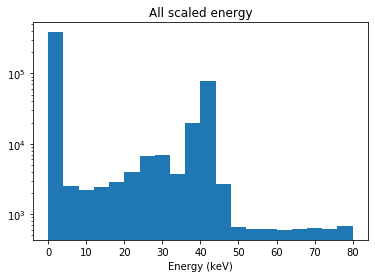

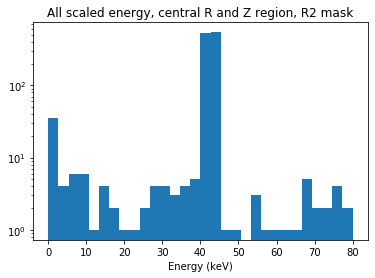

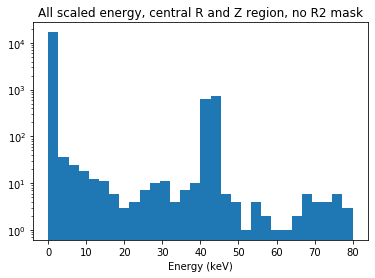

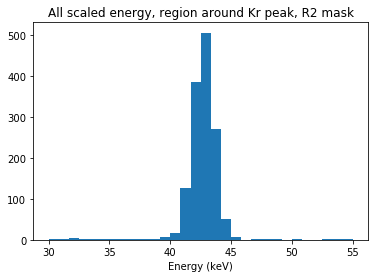

Correcting energies...
0 / 72734


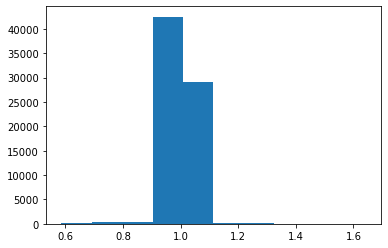

Fit a Gaussian with guess (A0, m0, s0) = (208.0, 1, 0.038222715593845505)


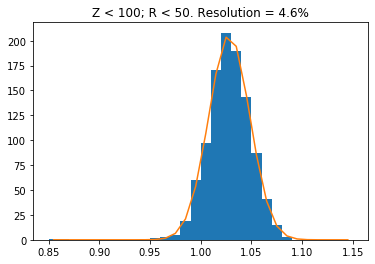

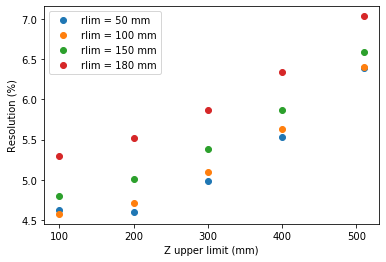

Innermost resolution =  4.62 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.621990038162075, 100100: 4.573905322956396, 100150: 4.801903732463435, 100180: 5.298488902788214, 200050: 4.602001277120906, 200100: 4.70544494133741, 200150: 5.012419252246625, 200180: 5.516857326491189, 300050: 4.985098603991587, 300100: 5.092187407639197, 300150: 5.385991691417916, 300180: 5.87009507856739, 400050: 5.530953031890722, 400100: 5.635791745170368, 400150: 5.873075493574089, 400180: 6.343324722855801, 510050: 6.394448738656681, 510100: 6.401188826760551, 510150: 6.591869833104066, 510180: 7.034601388355576}

================ CHECKING R2 CUT = 0.98 ================
Peak range = 6753.6 , 13524.5
Selected percentage = 10.4 \%


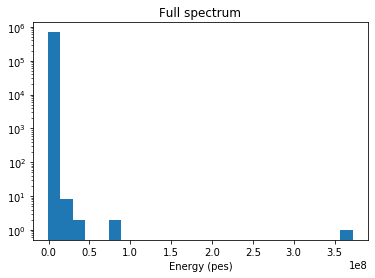

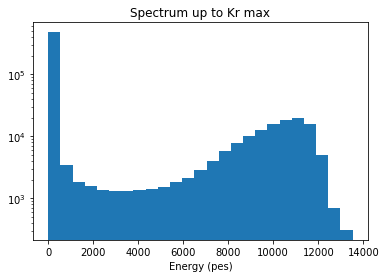

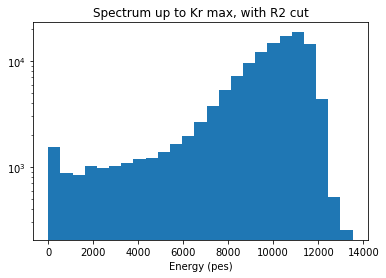

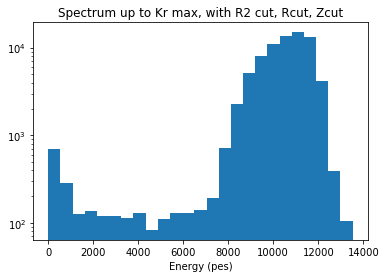

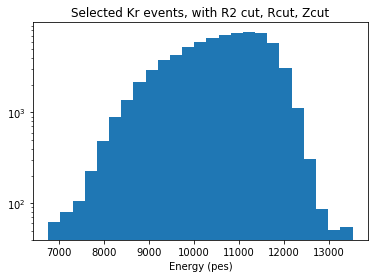

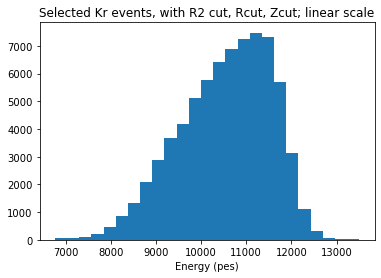

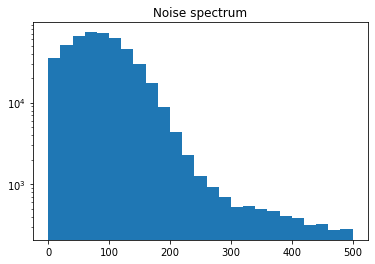

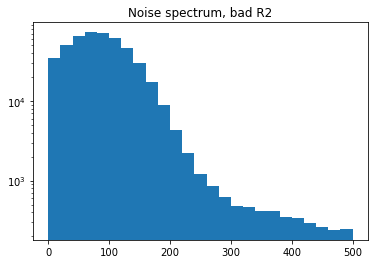

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


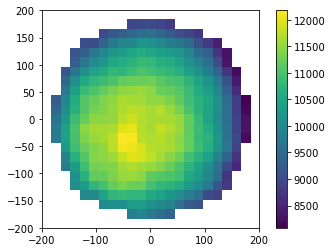

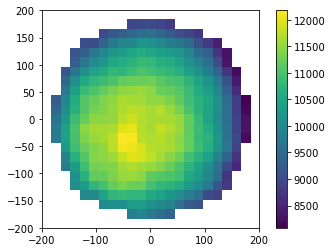

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.5
200000 / 589977
Est remaining = 5.0
300000 / 589977
Est remaining = 3.8
400000 / 589977
Est remaining = 2.4
500000 / 589977
Est remaining = 1.2


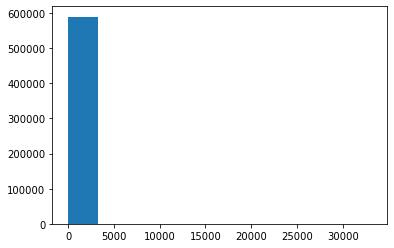

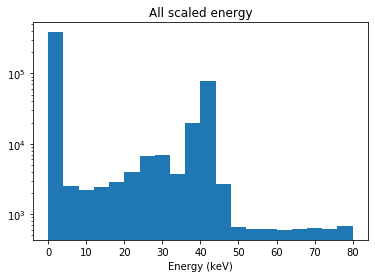

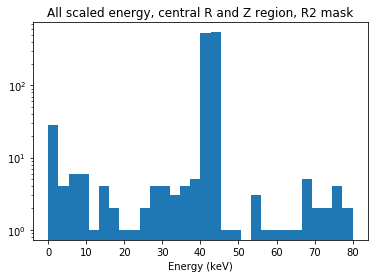

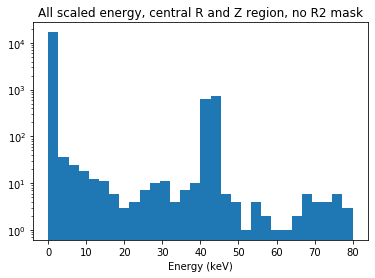

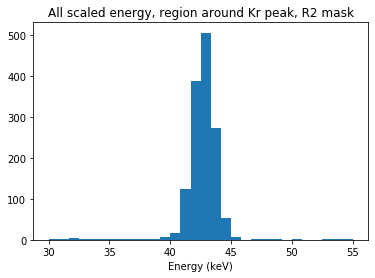

Correcting energies...
0 / 72500


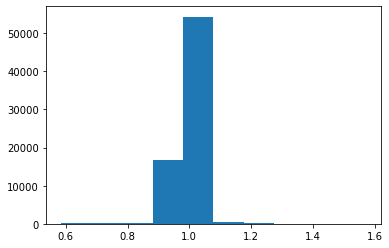

Fit a Gaussian with guess (A0, m0, s0) = (206.0, 1, 0.03827671291113318)


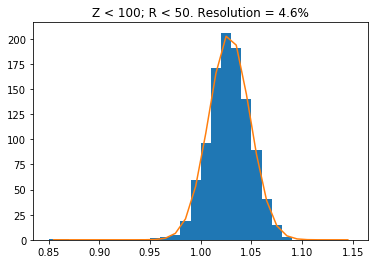

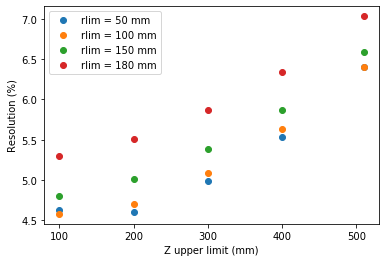

Innermost resolution =  4.62 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.624715338205598, 100100: 4.57747128538374, 100150: 4.805810403977094, 100180: 5.301374995002874, 200050: 4.606017045915654, 200100: 4.695916569440918, 200150: 5.005882441569676, 200180: 5.511302873754313, 300050: 4.984221980658652, 300100: 5.087761059030601, 300150: 5.383898076160804, 300180: 5.871726502893542, 400050: 5.530580431737143, 400100: 5.632752554373484, 400150: 5.870252892765936, 400180: 6.343726247233399, 510050: 6.397518531404217, 510100: 6.399192394092488, 510150: 6.589533519111657, 510180: 7.033792091300414}

================ CHECKING R2 CUT = 0.99 ================
Peak range = 6789.0 , 13520.0
Selected percentage = 10.3 \%


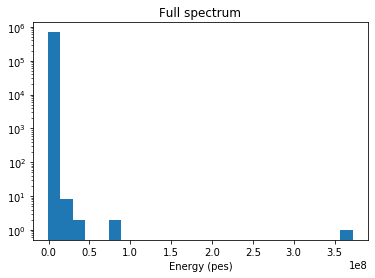

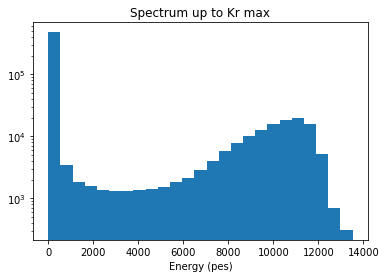

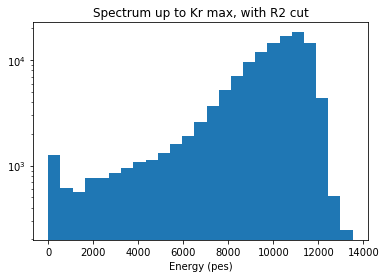

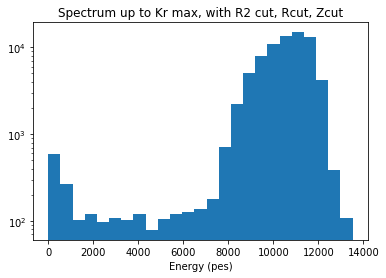

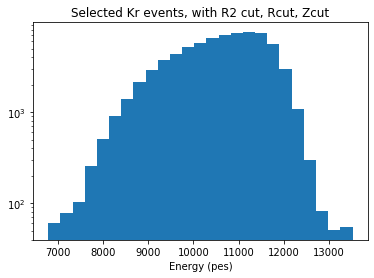

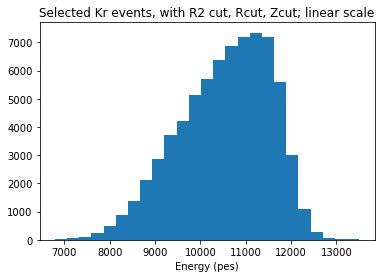

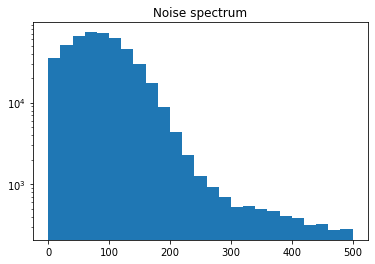

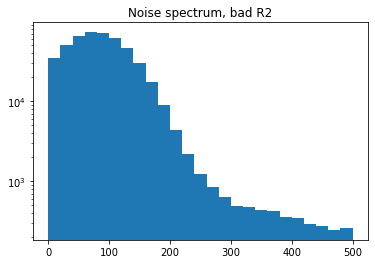

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


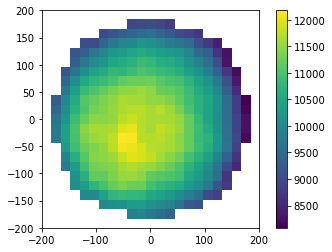

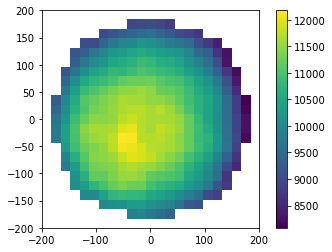

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.1
200000 / 589977
Est remaining = 5.0
300000 / 589977
Est remaining = 3.7
400000 / 589977
Est remaining = 2.4
500000 / 589977
Est remaining = 1.1


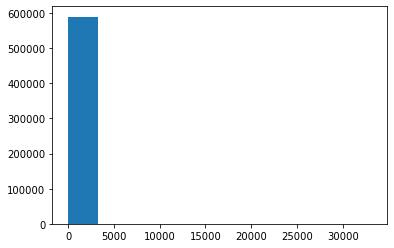

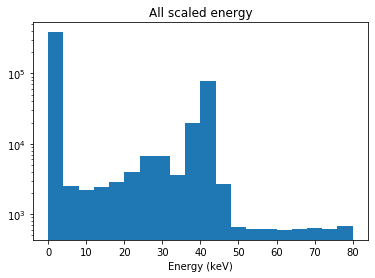

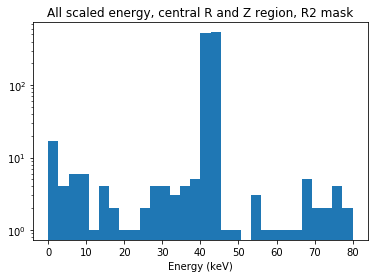

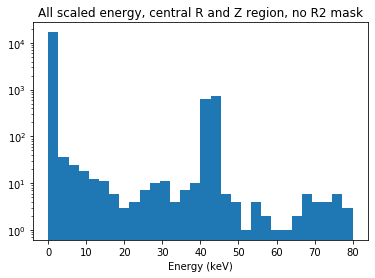

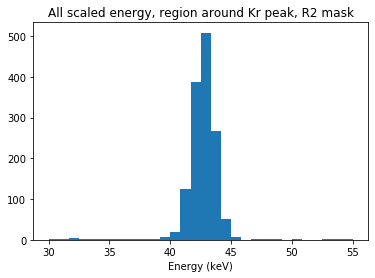

Correcting energies...
0 / 71991


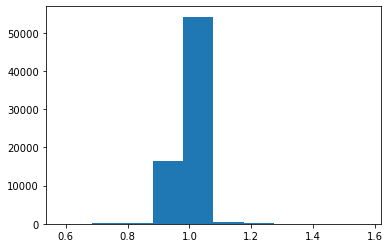

Fit a Gaussian with guess (A0, m0, s0) = (210.0, 1, 0.038345488192434315)


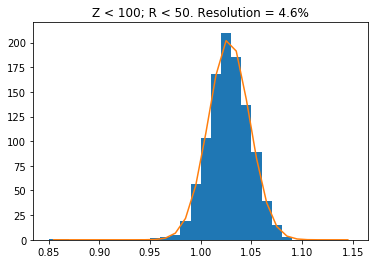

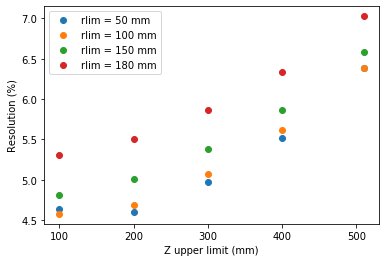

Innermost resolution =  4.63 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.633708805346679, 100100: 4.577705799807489, 100150: 4.807525825927549, 100180: 5.302011747272254, 200050: 4.598968665528392, 200100: 4.693432742719154, 200150: 5.006714100657363, 200180: 5.511192273318285, 300050: 4.977281127555169, 300100: 5.077280671181403, 300150: 5.378343624435548, 300180: 5.867112478503148, 400050: 5.524077807227349, 400100: 5.622428928919255, 400150: 5.863504495658284, 400180: 6.339905093632333, 510050: 6.3876845890828395, 510100: 6.3858732575127926, 510150: 6.579330726300691, 510180: 7.026343184437829}

================ CHECKING R2 CUT = 0.995 ================
Peak range = 6825.3 , 13553.9
Selected percentage = 9.6 \%


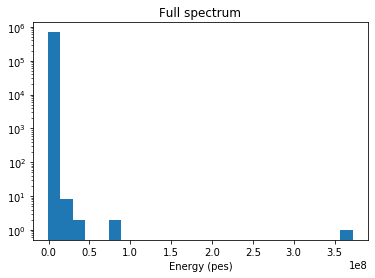

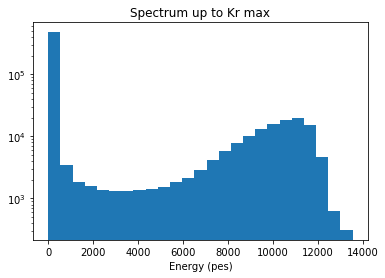

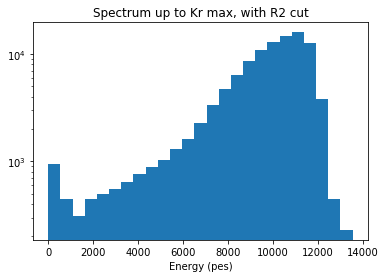

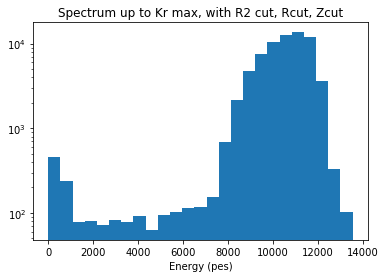

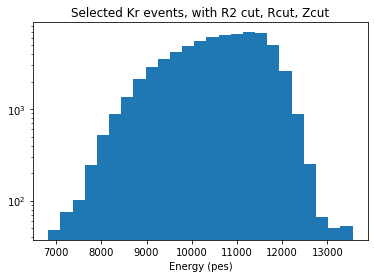

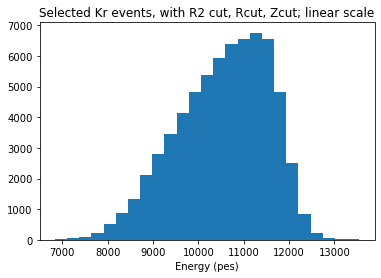

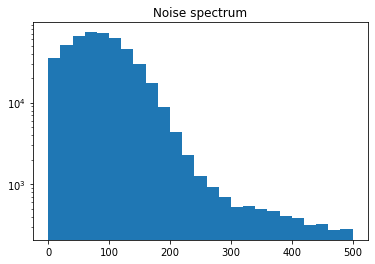

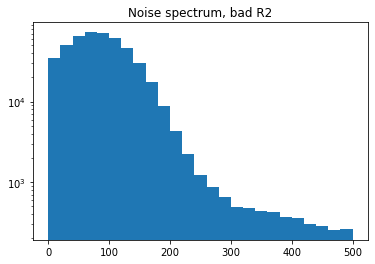

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


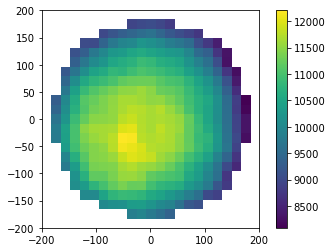

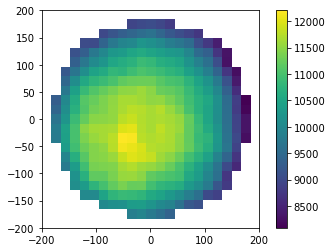

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 5.4
200000 / 589977
Est remaining = 4.7
300000 / 589977
Est remaining = 3.6
400000 / 589977
Est remaining = 2.4
500000 / 589977
Est remaining = 1.1


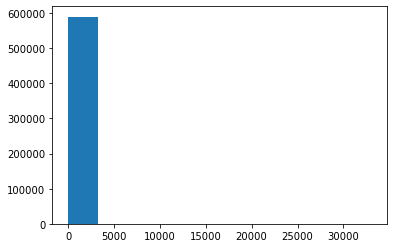

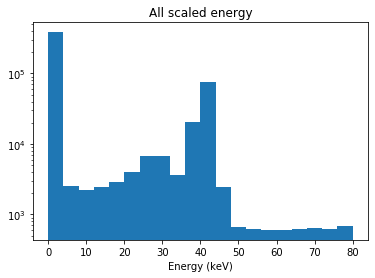

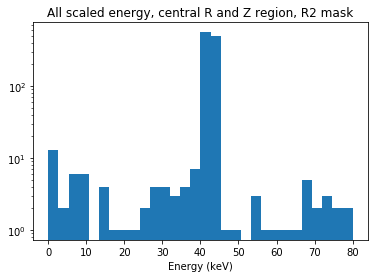

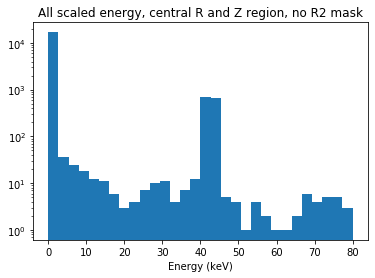

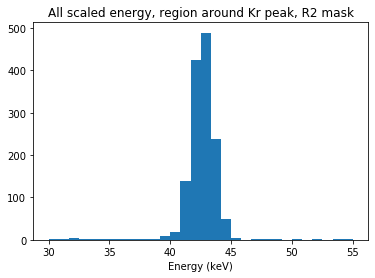

Correcting energies...
0 / 66593


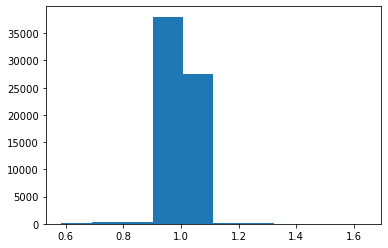

Fit a Gaussian with guess (A0, m0, s0) = (211.0, 1, 0.038390171897131904)


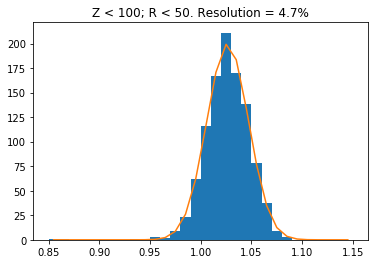

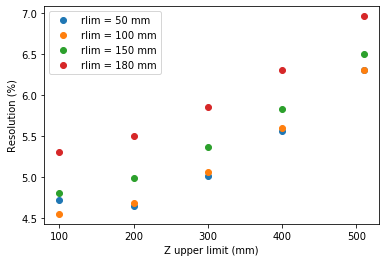

Innermost resolution =  4.72 %
Outermost resolution =  6.96 %
All resolutions: {100050: 4.720316611571979, 100100: 4.555670802028834, 100150: 4.804982281311927, 100180: 5.3085428250083915, 200050: 4.647834956444486, 200100: 4.684295975706427, 200150: 4.995544754865696, 200180: 5.509144813974327, 300050: 5.015003936735333, 300100: 5.06929051213316, 300150: 5.364444384235268, 300180: 5.859020154720652, 400050: 5.55943312699566, 400100: 5.602287200260591, 400150: 5.831156277897828, 400180: 6.311336078719134, 510050: 6.3061630749156246, 510100: 6.31161139395641, 510150: 6.500693041717485, 510180: 6.962085948076027}


In [21]:
# r2 scan
r2s = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.995])
res_vs_zr_vs_r2 = []
goodfit = []
for r2 in r2s:
    print('\n================ CHECKING R2 CUT =', r2, '================')
    try:
        self_res_vs_zr = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, r2)
        res_vs_zr_vs_r2.append(self_res_vs_zr)
        goodfit.append(True)
    except:
        goodfit.append(False)
goodfit = np.array(goodfit)

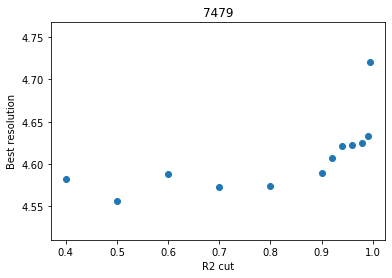

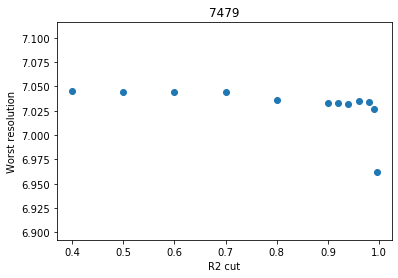

In [22]:
r2inner = [ list(x.values())[0] for x in res_vs_zr_vs_r2 ]
r2outer = [ list(x.values())[-1] for x in res_vs_zr_vs_r2 ]

plt.plot(r2s[goodfit], r2inner, 'o')
plt.ylim(min(r2inner)*0.99, max(r2inner)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Best resolution')
plt.show()

plt.plot(r2s[goodfit], r2outer, 'o')
plt.ylim(min(r2outer)*0.99, max(r2outer)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Worst resolution')
plt.show()

Peak range = 6685.0 , 13543.3
Selected percentage = 10.5 \%


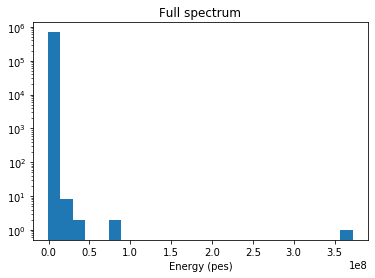

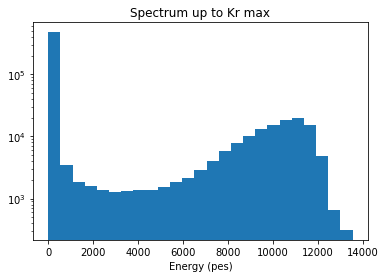

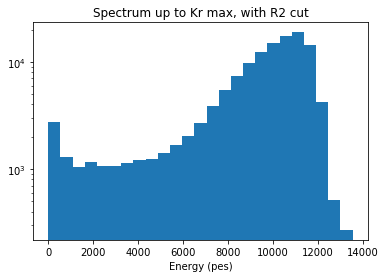

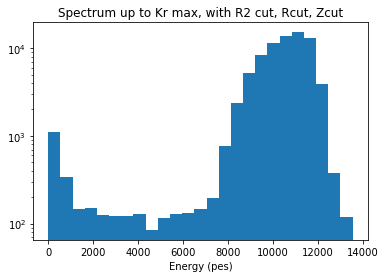

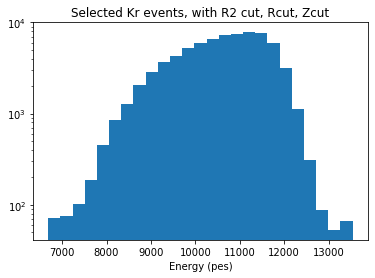

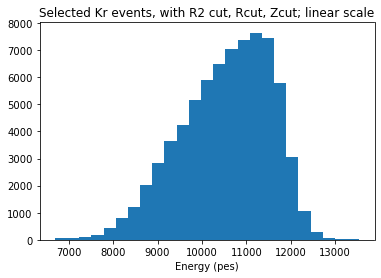

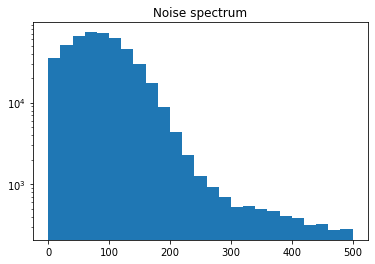

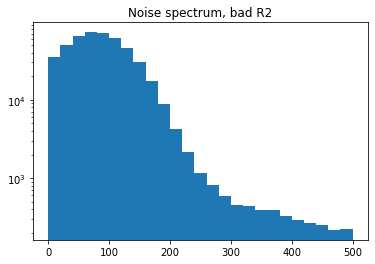

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


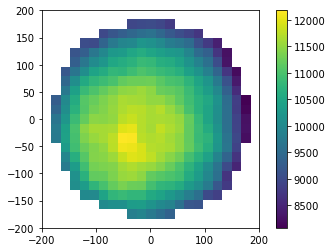

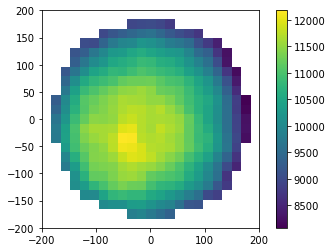

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.7
200000 / 589977
Est remaining = 5.1
300000 / 589977
Est remaining = 3.7
400000 / 589977
Est remaining = 2.4
500000 / 589977
Est remaining = 1.1


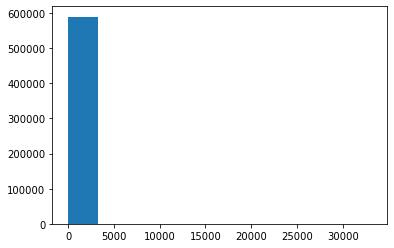

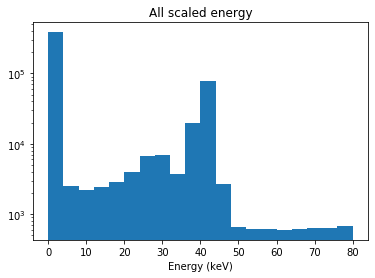

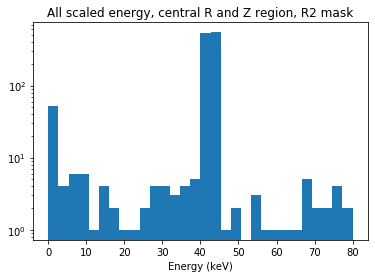

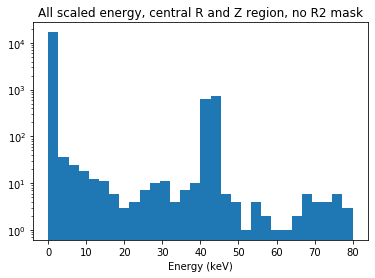

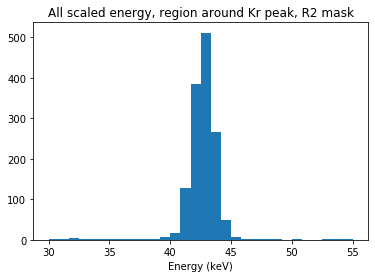

Correcting energies...
0 / 72993


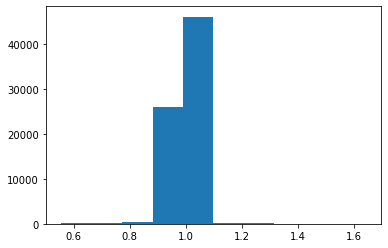

Fit a Gaussian with guess (A0, m0, s0) = (213.0, 1, 0.03819458387143255)


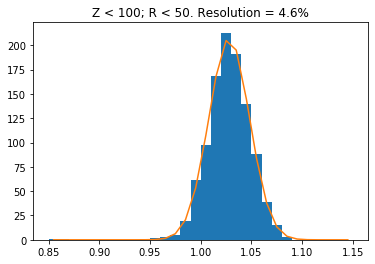

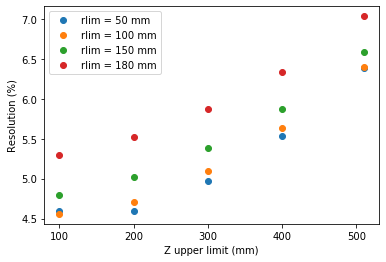

Innermost resolution =  4.59 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.589939468387972, 100100: 4.557788496964596, 100150: 4.798979610306696, 100180: 5.298312806699287, 200050: 4.589574729435558, 200100: 4.704209899456848, 200150: 5.016852004081788, 200180: 5.517355233805127, 300050: 4.976058417366219, 300100: 5.091746304165566, 300150: 5.385011677076099, 300180: 5.866307211663332, 400050: 5.531031931930349, 400100: 5.636358213770477, 400150: 5.86870671220523, 400180: 6.338110098778607, 510050: 6.390255595642891, 510100: 6.402320979865172, 510150: 6.58907055751231, 510180: 7.032671083478491}
Peak range = 6691.3 , 13599.5
Selected percentage = 10.5 \%


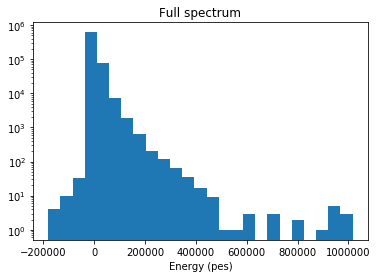

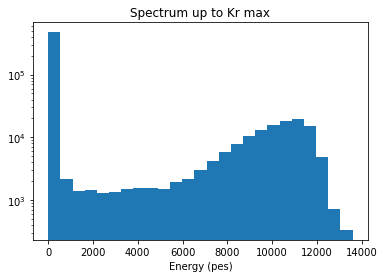

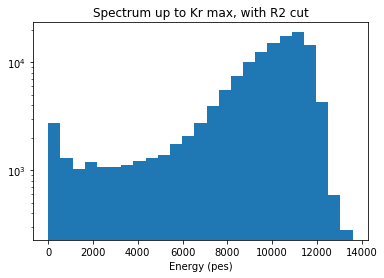

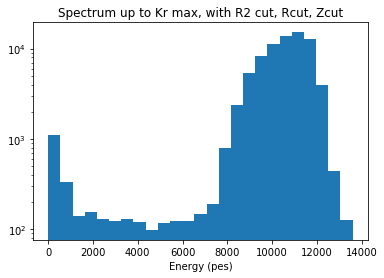

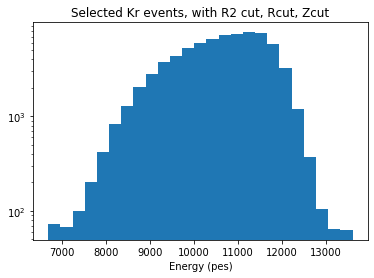

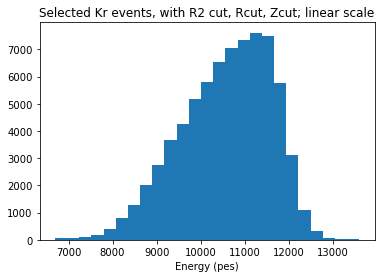

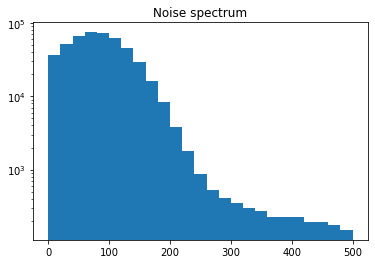

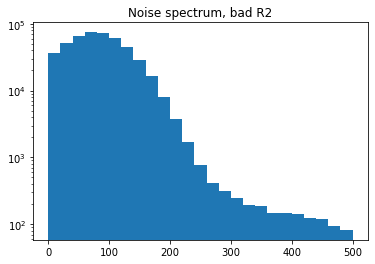

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


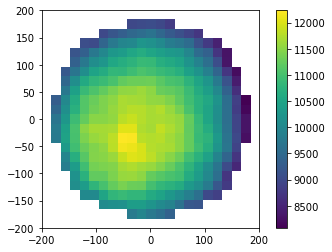

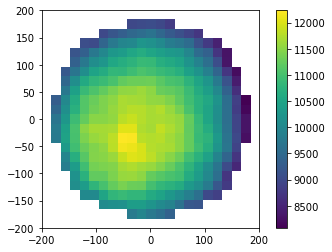

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 8.0
200000 / 589977
Est remaining = 5.6
300000 / 589977
Est remaining = 4.0
400000 / 589977
Est remaining = 2.6
500000 / 589977
Est remaining = 1.2


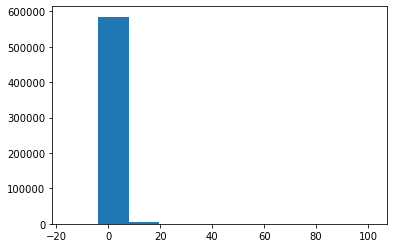

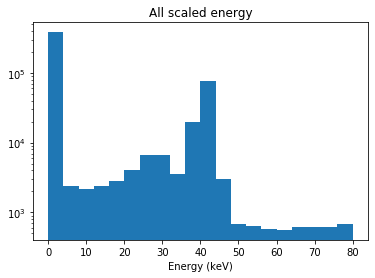

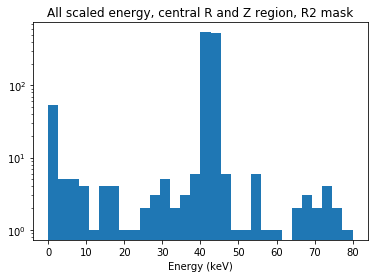

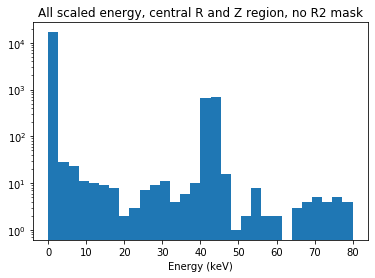

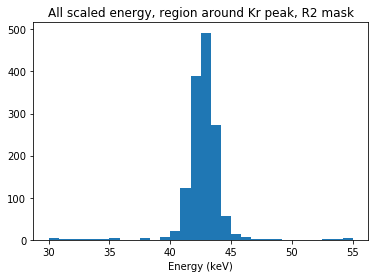

Correcting energies...
0 / 72994


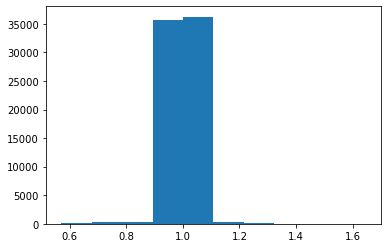

Fit a Gaussian with guess (A0, m0, s0) = (212.0, 1, 0.03856157007501802)


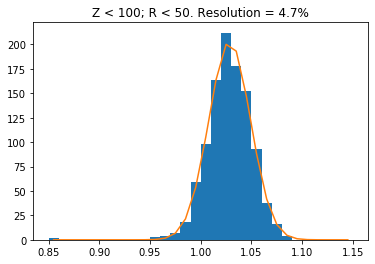

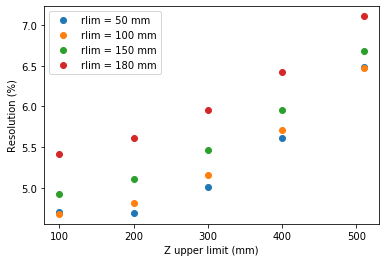

Innermost resolution =  4.7 %
Outermost resolution =  7.11 %
All resolutions: {100050: 4.697610469193286, 100100: 4.678014806068919, 100150: 4.925090116706728, 100180: 5.415541054365649, 200050: 4.686028917121963, 200100: 4.8066824391846055, 200150: 5.110484145199601, 200180: 5.617261719326031, 300050: 5.01380102019, 300100: 5.159456022093704, 300150: 5.468085139018526, 300180: 5.9513940211684275, 400050: 5.616669448571427, 400100: 5.705991486674713, 400150: 5.961187650020672, 400180: 6.424603297821328, 510050: 6.486871510486702, 510100: 6.4772967328153115, 510150: 6.682577310043218, 510180: 7.110319335290984}
Peak range = 6688.7 , 13569.5
Selected percentage = 10.5 \%


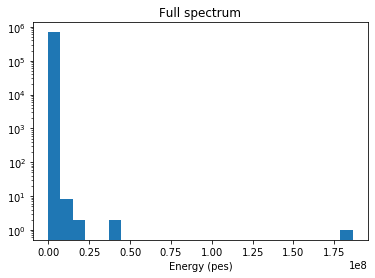

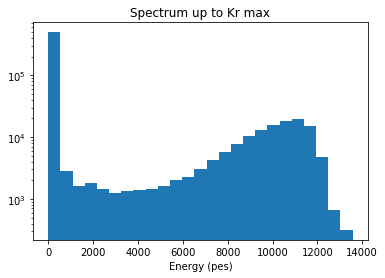

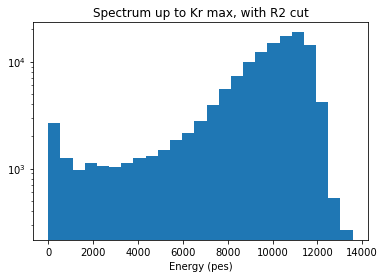

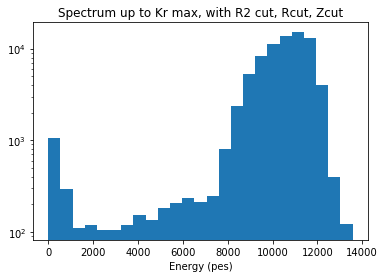

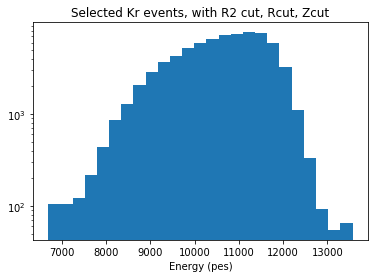

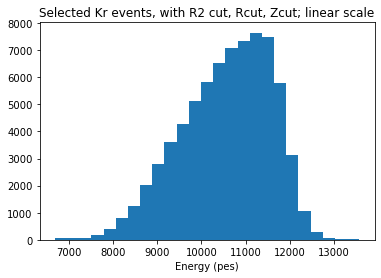

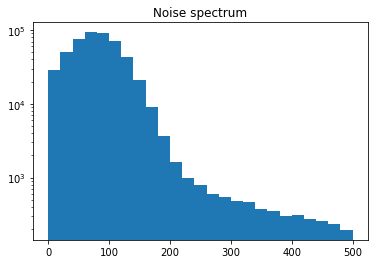

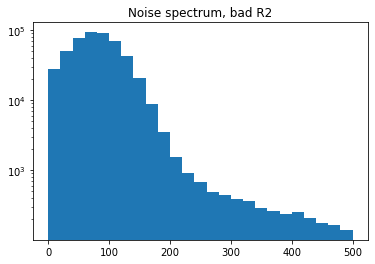

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


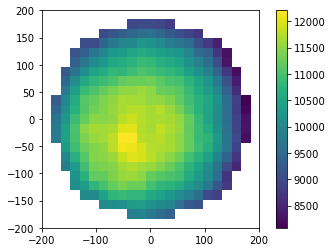

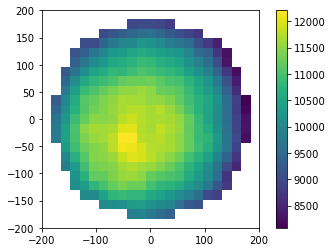

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 6.0
200000 / 589977
Est remaining = 4.5
300000 / 589977
Est remaining = 3.5
400000 / 589977
Est remaining = 2.3
500000 / 589977
Est remaining = 1.1


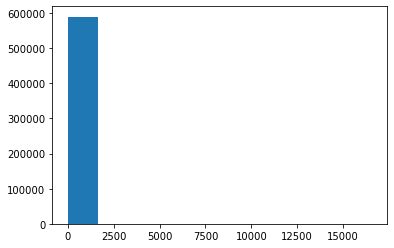

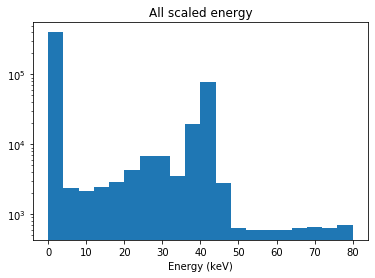

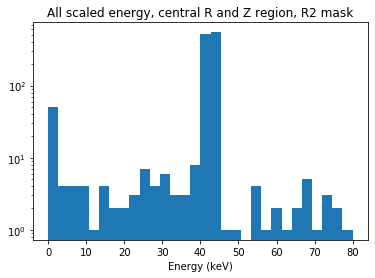

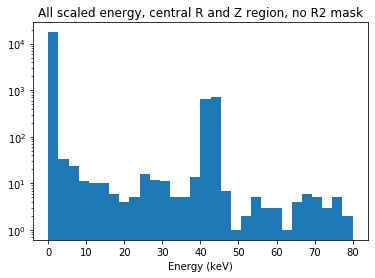

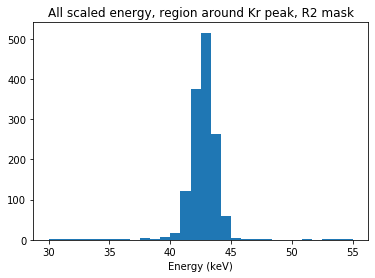

Correcting energies...
0 / 72995


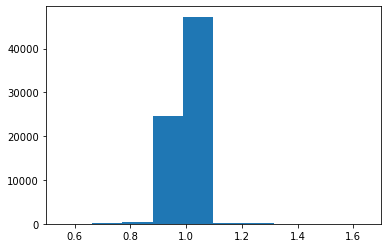

Fit a Gaussian with guess (A0, m0, s0) = (201.0, 1, 0.03820794424645517)


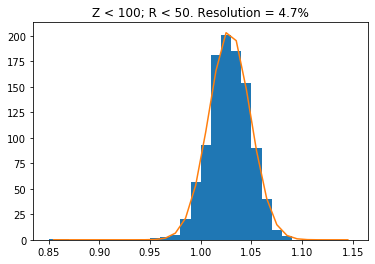

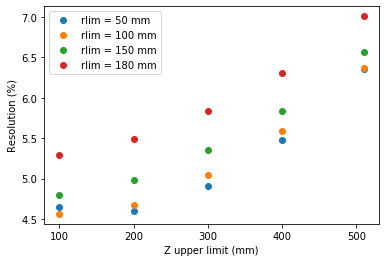

Innermost resolution =  4.65 %
Outermost resolution =  7.01 %
All resolutions: {100050: 4.652405737025842, 100100: 4.562085760849533, 100150: 4.792576413757081, 100180: 5.287411834806406, 200050: 4.594074129153832, 200100: 4.673581052488187, 200150: 4.987574646690671, 200180: 5.491567279036291, 300050: 4.908333763425049, 300100: 5.042424000196684, 300150: 5.354127435330901, 300180: 5.834635073397386, 400050: 5.472572114290126, 400100: 5.593869267948132, 400150: 5.840981229452675, 400180: 6.311173670611625, 510050: 6.356228047729, 510100: 6.373863860062117, 510150: 6.569410249940138, 510180: 7.009331633936209}


In [23]:
try:
    pre_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    post_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_post, 0.9)
    avg_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_avg, 0.9)
except:
    pass

In [24]:
try:
    print('Inner res for pre, post, avg:')
    print(round(list(pre_res.values())[0], 2), ',', round(list(post_res.values())[0], 2), ',', round(list(avg_res.values())[0], 2))
    print('Outer res for pre, post, avg:')
    print(round(list(pre_res.values())[-1], 2), ',', round(list(post_res.values())[-1], 2), ',', round(list(avg_res.values())[-1], 2))
except:
    pass

Inner res for pre, post, avg:
4.59 , 4.7 , 4.65
Outer res for pre, post, avg:
7.03 , 7.11 , 7.01


Peak range = 6685.0 , 13543.3
Selected percentage = 10.5 \%


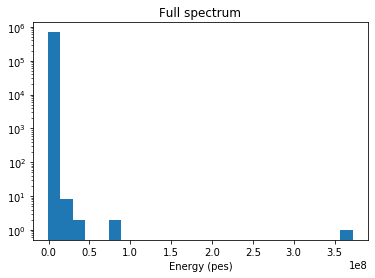

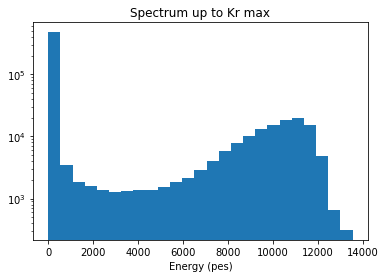

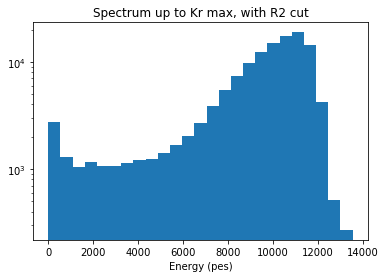

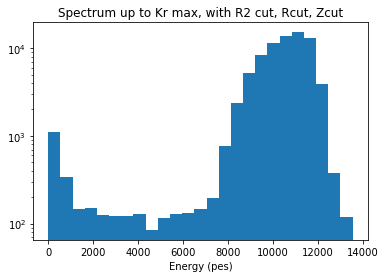

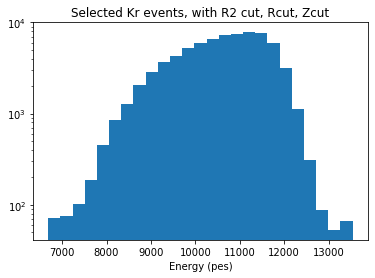

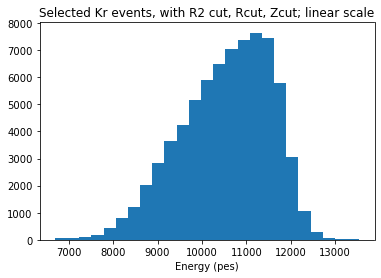

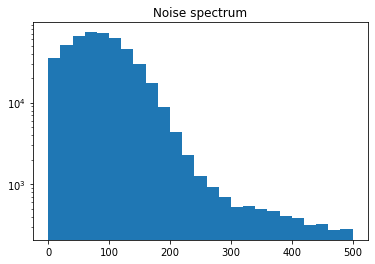

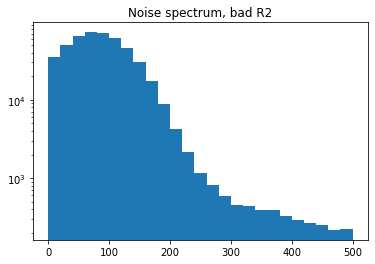

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


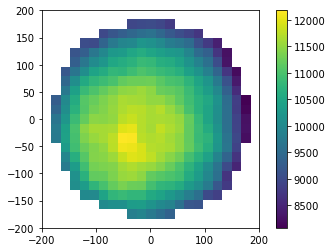

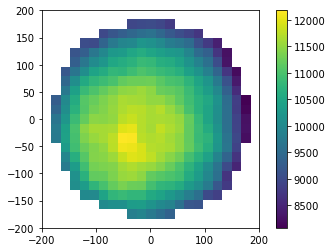

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 5.6
200000 / 589977
Est remaining = 4.6
300000 / 589977
Est remaining = 3.6
400000 / 589977
Est remaining = 2.6
500000 / 589977
Est remaining = 1.2


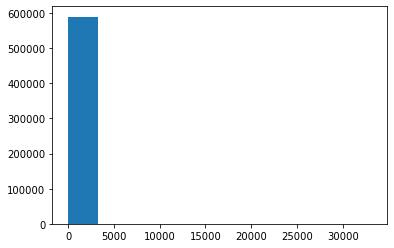

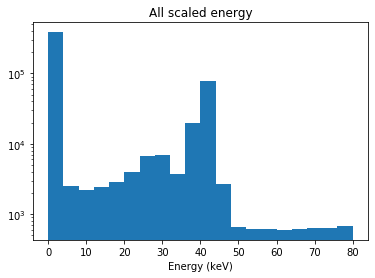

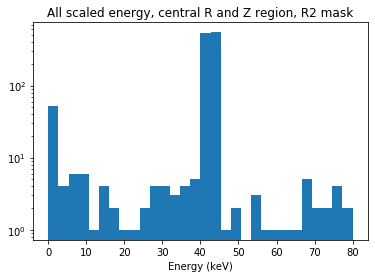

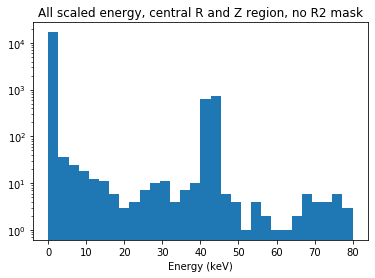

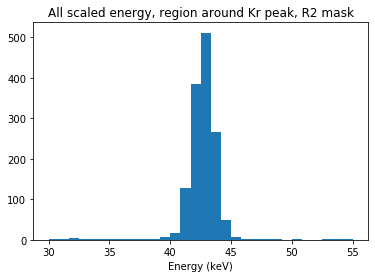

Correcting energies...
0 / 72993


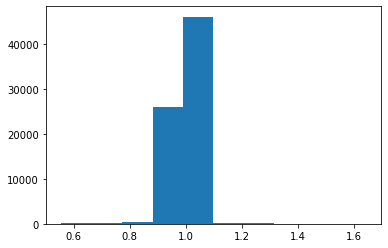

Fit a Gaussian with guess (A0, m0, s0) = (213.0, 1, 0.03819458387143255)


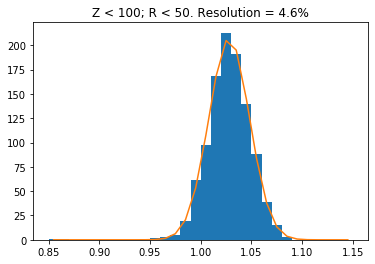

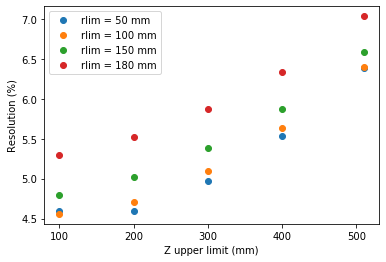

Innermost resolution =  4.59 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.589939468387972, 100100: 4.557788496964596, 100150: 4.798979610306696, 100180: 5.298312806699287, 200050: 4.589574729435558, 200100: 4.704209899456848, 200150: 5.016852004081788, 200180: 5.517355233805127, 300050: 4.976058417366219, 300100: 5.091746304165566, 300150: 5.385011677076099, 300180: 5.866307211663332, 400050: 5.531031931930349, 400100: 5.636358213770477, 400150: 5.86870671220523, 400180: 6.338110098778607, 510050: 6.390255595642891, 510100: 6.402320979865172, 510150: 6.58907055751231, 510180: 7.032671083478491}
Peak range = 6719.0 , 13548.8
Selected percentage = 10.2 \%


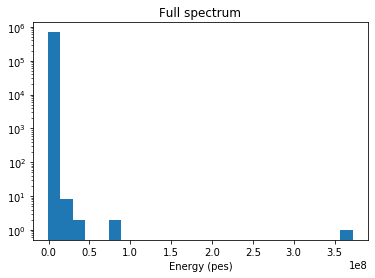

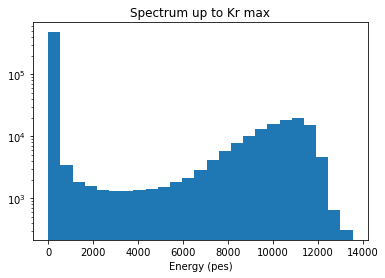

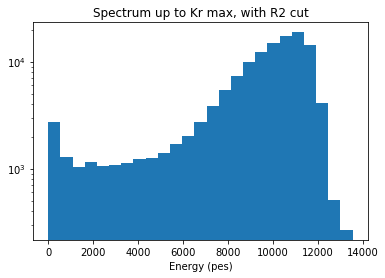

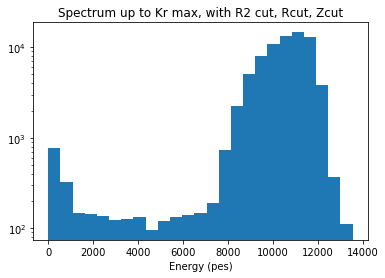

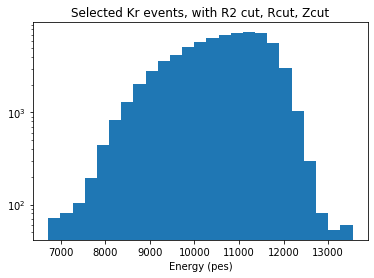

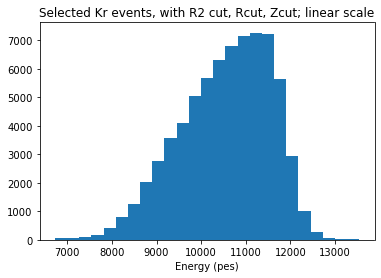

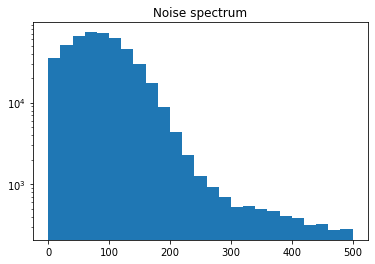

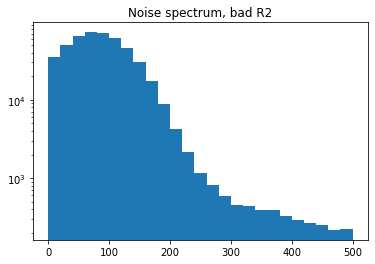

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


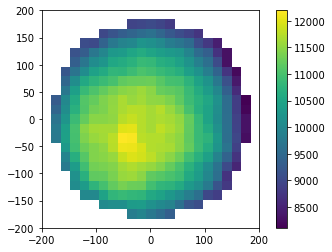

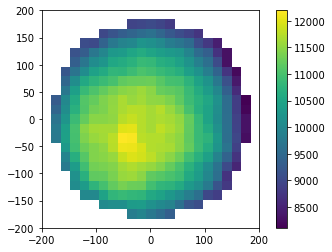

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 7.6
200000 / 589977
Est remaining = 6.0
300000 / 589977
Est remaining = 4.3
400000 / 589977
Est remaining = 2.7
500000 / 589977
Est remaining = 1.4


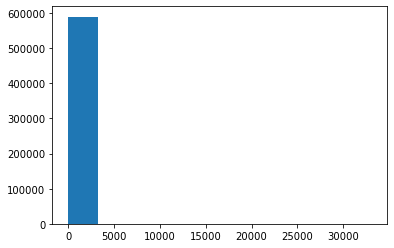

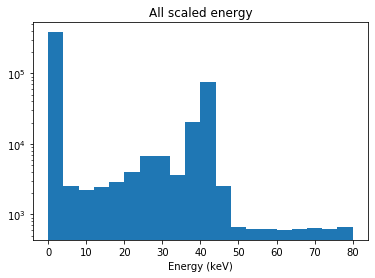

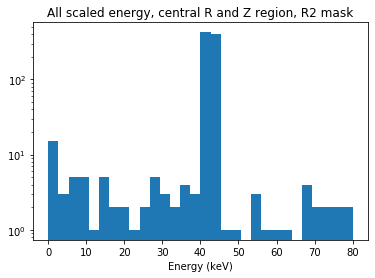

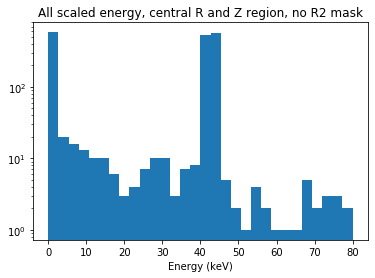

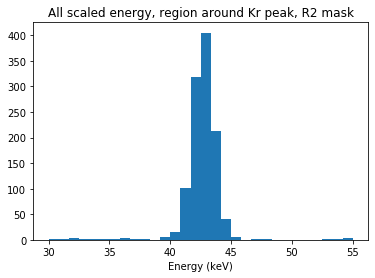

Correcting energies...
0 / 70809


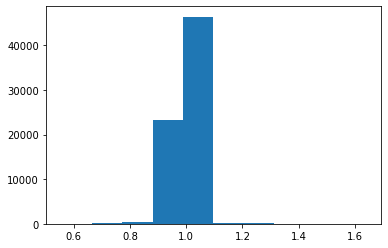

Fit a Gaussian with guess (A0, m0, s0) = (173.0, 1, 0.04472655208414483)


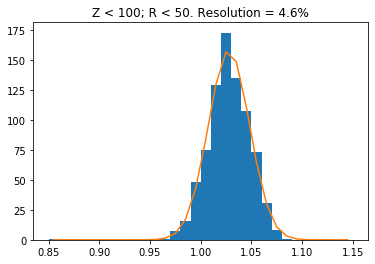

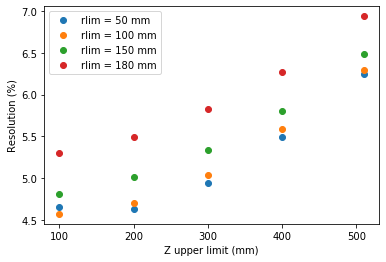

Innermost resolution =  4.65 %
Outermost resolution =  6.94 %
All resolutions: {100050: 4.6491060047270025, 100100: 4.568937197908051, 100150: 4.810166560038915, 100180: 5.2944171323468, 200050: 4.632675803851311, 200100: 4.703362104415131, 200150: 5.007209882838238, 200180: 5.4964238155219345, 300050: 4.937723612282282, 300100: 5.039329730733872, 300150: 5.333348515442701, 300180: 5.821936306071842, 400050: 5.4965297055240985, 400100: 5.585369188393659, 400150: 5.801238362567008, 400180: 6.267973924043588, 510050: 6.251667921561101, 510100: 6.299188172251389, 510150: 6.492577165542521, 510180: 6.940680179502946}


In [25]:
try:
    res_gauss = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    res_rms = check_resolution(histat_Zrms, histat_events_energy_subtracted_pre, 0.9)
except:
    pass

In [26]:
try:
    print('Inner res for rms, gauss:')
    print(round(list(res_rms.values())[0], 2), ',', round(list(res_gauss.values())[0], 2))
    print('Outer res for rms, gauss:')
    print(round(list(res_rms.values())[-1], 2), ',', round(list(res_gauss.values())[-1], 2))
except:
    pass

Inner res for rms, gauss:
4.65 , 4.59
Outer res for rms, gauss:
6.94 , 7.03


Peak range = 6685.0 , 13543.3
Selected percentage = 10.5 \%


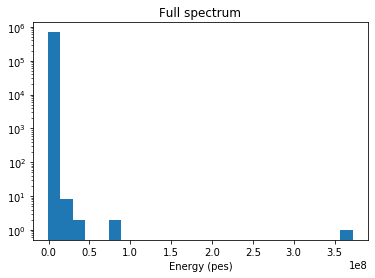

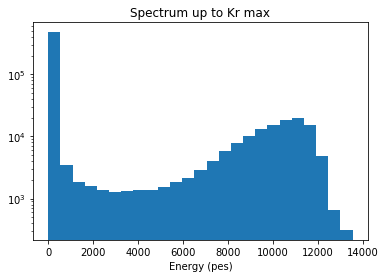

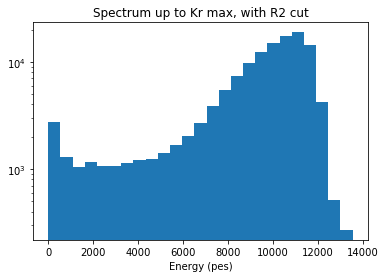

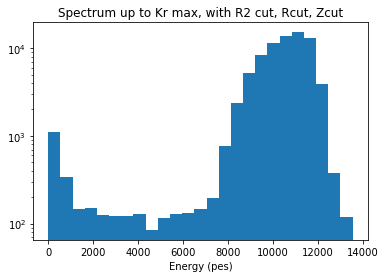

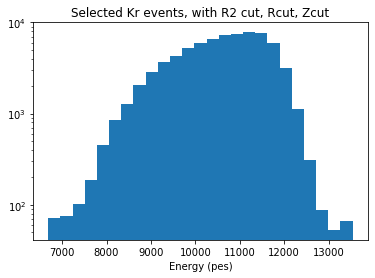

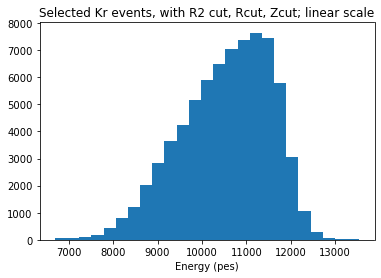

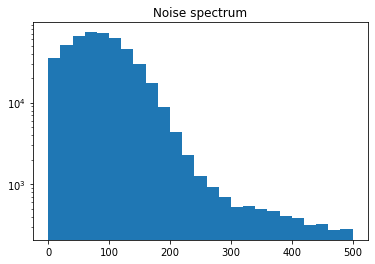

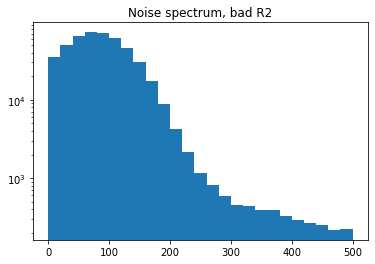

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:89: RuntimeWarning: invalid value encountered in true_divide


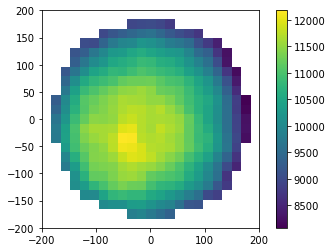

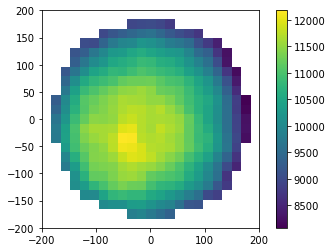

Correcting energies...
0 / 589977
100000 / 589977
Est remaining = 9.2
200000 / 589977
Est remaining = 5.6
300000 / 589977
Est remaining = 3.8
400000 / 589977
Est remaining = 2.4
500000 / 589977
Est remaining = 1.1


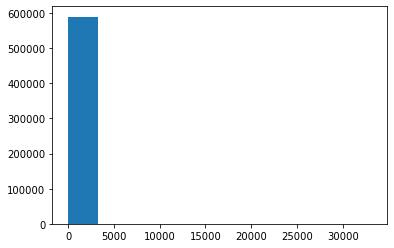

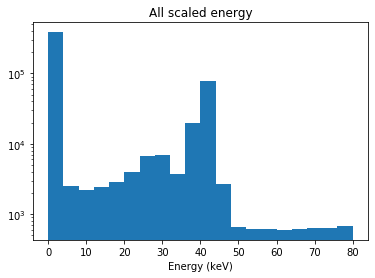

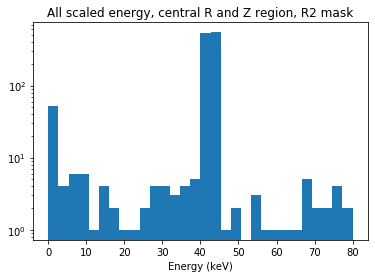

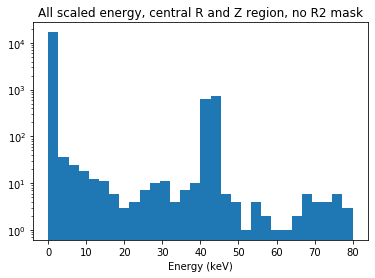

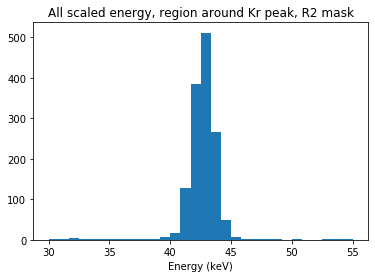

Correcting energies...
0 / 72993


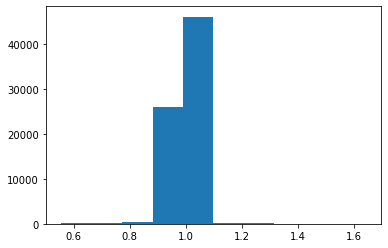

Fit a Gaussian with guess (A0, m0, s0) = (213.0, 1, 0.03819458387143255)


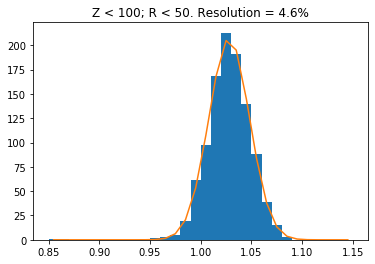

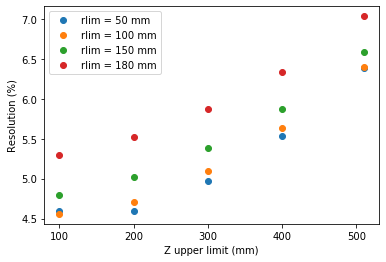

Innermost resolution =  4.59 %
Outermost resolution =  7.03 %
All resolutions: {100050: 4.589939468387972, 100100: 4.557788496964596, 100150: 4.798979610306696, 100180: 5.298312806699287, 200050: 4.589574729435558, 200100: 4.704209899456848, 200150: 5.016852004081788, 200180: 5.517355233805127, 300050: 4.976058417366219, 300100: 5.091746304165566, 300150: 5.385011677076099, 300180: 5.866307211663332, 400050: 5.531031931930349, 400100: 5.636358213770477, 400150: 5.86870671220523, 400180: 6.338110098778607, 510050: 6.390255595642891, 510100: 6.402320979865172, 510150: 6.58907055751231, 510180: 7.032671083478491}


{100050: 4.589939468387972,
 100100: 4.557788496964596,
 100150: 4.798979610306696,
 100180: 5.298312806699287,
 200050: 4.589574729435558,
 200100: 4.704209899456848,
 200150: 5.016852004081788,
 200180: 5.517355233805127,
 300050: 4.976058417366219,
 300100: 5.091746304165566,
 300150: 5.385011677076099,
 300180: 5.866307211663332,
 400050: 5.531031931930349,
 400100: 5.636358213770477,
 400150: 5.86870671220523,
 400180: 6.338110098778607,
 510050: 6.390255595642891,
 510100: 6.402320979865172,
 510150: 6.58907055751231,
 510180: 7.032671083478491}

In [27]:
# Output the proper map
check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)

In [28]:
print('Total time =',  round((time() - t0)/60,1), 'minutes')

Total time = 8.4 minutes
